In [1]:
from IPython.core.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import traceback
import numpy as np
import scipy.stats as ss
import yaml
import itertools
import sys
import os
import subprocess
from os import path
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

In [2]:
!ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning/*"

start : compute_metrics   0% session_2021-11-02_10-33-14_965419_run_000000000
start : compute_metrics   0% session_2021-11-02_13-54-20_413082_run_000000007
start : compute_metrics   0% session_2021-11-03_03-23-26_500136_run_000000053
start : compute_metrics   0% session_2021-11-02_16-44-01_042364_run_000000047
start : compute_metrics   0% session_2021-11-03_03-23-26_500136_run_000000124
start : compute_metrics   0% session_2021-11-03_03-23-26_500136_run_000000196
start : compute_metrics   0% session_2021-11-03_03-23-26_500136_run_000000267
start : compute_metrics   0% session_2021-11-03_03-23-26_500136_run_000000335
start : compute_metrics   0% session_2021-11-03_03-23-26_500136_run_000000404
start : compute_metrics   0% session_2021-11-03_03-23-26_500136_run_000000476
start : compute_metrics   0% session_2021-11-03_03-23-26_500136_run_000000544
start : compute_metrics   0% session_2021-11-03_03-23-26_500136_run_000000614
start : compute_metrics   0% session_2021-11-03_03-23-26_500136_

finish: compute_metrics   0% session_2021-11-03_03-23-26_500136_run_000000687
start : compute_metrics   1% session_2021-11-03_03-23-26_500136_run_000000689
average_translation_velocity: 0.08344706175987547
average_rotation_velocity: 0.07538523863583198
average_translation_velocity: 0.20371552142089105
average_rotation_velocity: 0.27824527144688366
finish: compute_metrics   1% session_2021-11-03_03-23-26_500136_run_000000546
start : compute_metrics   1% session_2021-11-03_03-23-26_500136_run_000000547
finish: compute_metrics   1% session_2021-11-04_08-00-57_167708_run_000000005
start : compute_metrics   1% session_2021-11-04_08-00-57_167708_run_000000007
finish: compute_metrics   1% session_2021-11-03_03-23-26_500136_run_000000337
start : compute_metrics   1% session_2021-11-03_03-23-26_500136_run_000000338
average_translation_velocity: 0.0855663626994248
average_rotation_velocity: 0.1961049376882755
average_translation_velocity: 0.20912400054654107
average_rotation_velocity: 0.07921201

average_translation_velocity: 0.0403373082231761
average_rotation_velocity: 0.023359944125098963
finish: compute_metrics   2% session_2021-11-02_16-44-01_042364_run_000000051
start : compute_metrics   2% session_2021-11-02_16-44-01_042364_run_000000052
average_translation_velocity: 0.2271696960491091
average_rotation_velocity: 0.11360773230674139
finish: compute_metrics   2% session_2021-11-04_08-00-57_167708_run_000000154
start : compute_metrics   2% session_2021-11-04_08-00-57_167708_run_000000155
average_translation_velocity: 0.22792660240732462
average_rotation_velocity: 0.07542735043120316
average_translation_velocity: 0.26070343358600967
average_rotation_velocity: 0.09985752911634296
finish: compute_metrics   2% session_2021-11-04_08-00-57_167708_run_000000010
start : compute_metrics   2% session_2021-11-04_08-00-57_167708_run_000000011
average_translation_velocity: 0.24907296796208042
average_rotation_velocity: 0.0773104798137951
average_translation_velocity: 0.25477941090298994

average_translation_velocity: 0.11957601125429511
average_rotation_velocity: 0.07396008634849031
finish: compute_metrics   3% session_2021-11-03_03-23-26_500136_run_000000344
start : compute_metrics   3% session_2021-11-03_03-23-26_500136_run_000000345
average_translation_velocity: 0.23334159816736957
average_rotation_velocity: 0.16016762717971256
finish: compute_metrics   3% session_2021-11-04_08-00-57_167708_run_000000084
start : compute_metrics   3% session_2021-11-04_08-00-57_167708_run_000000085
average_translation_velocity: 5.5147938039492415e-05
average_rotation_velocity: 2.5701063332479967e-05
finish: compute_metrics   3% session_2021-11-03_03-23-26_500136_run_000000553
start : compute_metrics   3% session_2021-11-03_03-23-26_500136_run_000000554
average_translation_velocity: 0.19471108979330276
average_rotation_velocity: 0.2202413161496271
average_translation_velocity: 0.23054687646443853
average_rotation_velocity: 0.11945076129054388
finish: compute_metrics   3% session_2021-

average_translation_velocity: 0.22168009032486735
average_rotation_velocity: 0.20255359814635654
average_translation_velocity: 5.514835443260674e-05
average_rotation_velocity: 2.570089441008583e-05
finish: compute_metrics   4% session_2021-11-03_03-23-26_500136_run_000000065
start : compute_metrics   4% session_2021-11-03_03-23-26_500136_run_000000066
finish: compute_metrics   4% session_2021-11-02_16-44-01_042364_run_000000057
start : compute_metrics   4% session_2021-11-02_16-44-01_042364_run_000000058
average_translation_velocity: 0.21363188956150828
average_rotation_velocity: 0.10332529518077785
finish: compute_metrics   4% session_2021-11-02_16-20-43_405511_run_000000002
start : compute_metrics   4% session_2021-11-02_16-20-43_405511_run_000000003
average_translation_velocity: 0.22324237549124532
average_rotation_velocity: 0.10772861649401345
average_translation_velocity: 0.2122690502423745
average_rotation_velocity: 0.06615093111076104
finish: compute_metrics   4% session_2021-11

average_translation_velocity: 0.23553238482063119
average_rotation_velocity: 0.1178200330928218
finish: compute_metrics   5% session_2021-11-03_03-23-26_500136_run_000000423
start : compute_metrics   5% session_2021-11-03_03-23-26_500136_run_000000424
finish: compute_metrics   5% session_2021-11-04_08-00-57_167708_run_000000019
start : compute_metrics   5% session_2021-11-04_08-00-57_167708_run_000000020
average_translation_velocity: 0.24828091251983309
average_rotation_velocity: 0.011854913310399057
average_translation_velocity: 0.19830890434231366
average_rotation_velocity: 0.0753967138122375
average_translation_velocity: 0.22810718950297426
average_rotation_velocity: 0.10524714703796066
finish: compute_metrics   5% session_2021-11-04_08-00-57_167708_run_000000089
start : compute_metrics   5% session_2021-11-04_08-00-57_167708_run_000000090
finish: compute_metrics   5% session_2021-11-02_10-33-14_965419_run_000000022
start : compute_metrics   5% session_2021-11-02_10-33-14_965419_run

average_translation_velocity: 0.22082835779024795
average_rotation_velocity: 0.09524474971382897
finish: compute_metrics   6% session_2021-11-04_08-00-57_167708_run_000000168
start : compute_metrics   6% session_2021-11-04_08-00-57_167708_run_000000169
finish: compute_metrics   6% session_2021-11-03_03-23-26_500136_run_000000425
start : compute_metrics   6% session_2021-11-03_03-23-26_500136_run_000000427
average_translation_velocity: 5.5147848903407766e-05
average_rotation_velocity: 2.5701102889641783e-05
finish: compute_metrics   6% session_2021-11-03_03-23-26_500136_run_000000634
start : compute_metrics   6% session_2021-11-03_03-23-26_500136_run_000000635
average_translation_velocity: 0.045954971299333035
average_rotation_velocity: 0.026551920418331803
finish: compute_metrics   6% session_2021-11-03_03-23-26_500136_run_000000070
start : compute_metrics   6% session_2021-11-03_03-23-26_500136_run_000000071
average_translation_velocity: 0.12572240328836665
average_rotation_velocity: 

finish: compute_metrics   7% session_2021-11-04_08-00-57_167708_run_000000023
start : compute_metrics   7% session_2021-11-04_08-00-57_167708_run_000000024
average_translation_velocity: 0.2229822541849694
average_rotation_velocity: 0.14175011412528118
average_translation_velocity: 0.2441832494166499
average_rotation_velocity: 0.17107011164771455
average_translation_velocity: 0.020577223761760056
average_rotation_velocity: 0.018460349089607406
finish: compute_metrics   7% session_2021-11-03_03-23-26_500136_run_000000290
start : compute_metrics   7% session_2021-11-03_03-23-26_500136_run_000000291
finish: compute_metrics   7% session_2021-11-03_03-23-26_500136_run_000000356
start : compute_metrics   7% session_2021-11-03_03-23-26_500136_run_000000357
finish: compute_metrics   7% session_2021-11-03_03-23-26_500136_run_000000496
start : compute_metrics   7% session_2021-11-03_03-23-26_500136_run_000000497
average_translation_velocity: 0.1709113347024724
average_rotation_velocity: 0.0625720

finish: compute_metrics   8% session_2021-11-04_08-00-57_167708_run_000000098
start : compute_metrics   8% session_2021-11-04_08-00-57_167708_run_000000099
finish: compute_metrics   8% session_2021-11-03_22-12-57_836780_run_000000008
start : compute_metrics   8% session_2021-11-03_22-12-57_836780_run_000000009
finish: compute_metrics   8% session_2021-11-03_03-23-26_500136_run_000000079
start : compute_metrics   8% session_2021-11-03_03-23-26_500136_run_000000080
average_translation_velocity: 0.23878032627823956
average_rotation_velocity: 0.08262320138313975
finish: compute_metrics   8% session_2021-11-03_03-23-26_500136_run_000000569
start : compute_metrics   8% session_2021-11-03_03-23-26_500136_run_000000570
average_translation_velocity: 0.23034145153320706
average_rotation_velocity: 0.10204293122202289
finish: compute_metrics   8% session_2021-11-03_03-23-26_500136_run_000000002
start : compute_metrics   8% session_2021-11-03_03-23-26_500136_run_000000003
average_translation_veloci

average_translation_velocity: 0.23518444653350842
average_rotation_velocity: 0.10862762401044236
average_translation_velocity: 0.2067897587098171
average_rotation_velocity: 0.10504595404243999
finish: compute_metrics  10% session_2021-11-03_03-23-26_500136_run_000000436
start : compute_metrics  10% session_2021-11-03_03-23-26_500136_run_000000437
finish: compute_metrics  10% session_2021-11-03_03-23-26_500136_run_000000299
start : compute_metrics  10% session_2021-11-03_03-23-26_500136_run_000000300
average_translation_velocity: 5.514536460943475e-05
average_rotation_velocity: 2.570029652275518e-05
average_translation_velocity: 0.22734111355539743
average_rotation_velocity: 0.1437238345204794
finish: compute_metrics  10% session_2021-11-03_03-23-26_500136_run_000000504
start : compute_metrics  10% session_2021-11-03_03-23-26_500136_run_000000505
finish: compute_metrics  10% session_2021-11-03_03-23-26_500136_run_000000647
start : compute_metrics  10% session_2021-11-03_03-23-26_500136_

average_translation_velocity: 0.19716942320750414
average_rotation_velocity: 0.07226091678855823
finish: compute_metrics  11% session_2021-11-04_08-00-57_167708_run_000000185
start : compute_metrics  11% session_2021-11-04_08-00-57_167708_run_000000187
average_translation_velocity: 0.26213437207957496
average_rotation_velocity: 0.06801011772553235
average_translation_velocity: 0.09755251602502128
average_rotation_velocity: 0.05537202600135236
finish: compute_metrics  11% session_2021-11-03_03-23-26_500136_run_000000650
finish: compute_metrics  11% session_2021-11-03_03-23-26_500136_run_000000086
start : compute_metrics  11% session_2021-11-03_03-23-26_500136_run_000000651
start : compute_metrics  11% session_2021-11-03_03-23-26_500136_run_000000087
average_translation_velocity: 5.514539014467893e-05
average_rotation_velocity: 2.5700825738089438e-05
average_translation_velocity: 0.2399203058459096
average_rotation_velocity: 0.16778739599651116
finish: compute_metrics  11% session_2021-1

finish: compute_metrics  12% session_2021-11-03_03-23-26_500136_run_000000163
start : compute_metrics  12% session_2021-11-03_03-23-26_500136_run_000000164
average_translation_velocity: 0.23383453711112073
average_rotation_velocity: 0.08303489017646828
average_translation_velocity: 0.06401970704464799
average_rotation_velocity: 0.013859041900787884
average_translation_velocity: 5.5145397135319104e-05
average_rotation_velocity: 2.570096698479119e-05
average_translation_velocity: 0.20770741061351475
average_rotation_velocity: 0.10343139455546865
finish: compute_metrics  12% session_2021-11-03_03-23-26_500136_run_000000013
start : compute_metrics  12% session_2021-11-03_03-23-26_500136_run_000000014
finish: compute_metrics  12% session_2021-11-03_03-23-26_500136_run_000000374
start : compute_metrics  12% session_2021-11-03_03-23-26_500136_run_000000375
average_translation_velocity: 0.21699746542571377
average_rotation_velocity: 0.17405285002657242
finish: compute_metrics  12% session_2021

average_translation_velocity: 5.5146133538679724e-05
average_rotation_velocity: 2.5701967823205716e-05
finish: compute_metrics  13% session_2021-11-04_08-00-57_167708_run_000000194
start : compute_metrics  13% session_2021-11-04_08-00-57_167708_run_000000197
average_translation_velocity: nan
average_rotation_velocity: nan
average_translation_velocity: 0.20527538931103262
average_rotation_velocity: 0.10810403541389874
average_translation_velocity: 0.21658574362664787
average_rotation_velocity: 0.12331776193781332
average_translation_velocity: 0.2530698576609967
average_rotation_velocity: 0.062252948624075675
average_translation_velocity: 0.20728421933647265
average_rotation_velocity: 0.11404457754241609
finish: compute_metrics  13% session_2021-11-03_03-23-26_500136_run_000000588
start : compute_metrics  13% session_2021-11-03_03-23-26_500136_run_000000589
finish: compute_metrics  13% session_2021-11-03_03-23-26_500136_run_000000657
start : compute_metrics  13% session_2021-11-03_03-23-

average_translation_velocity: 0.243586294835078
average_rotation_velocity: 0.15846041036127032
finish: compute_metrics  15% session_2021-11-03_03-23-26_500136_run_000000020
finish: compute_metrics  15% session_2021-11-03_03-23-26_500136_run_000000520
start : compute_metrics  15% session_2021-11-03_03-23-26_500136_run_000000021
start : compute_metrics  15% session_2021-11-03_03-23-26_500136_run_000000521
average_translation_velocity: 0.22176356936959782
average_rotation_velocity: 0.11095357390137743
finish: compute_metrics  15% session_2021-11-03_03-23-26_500136_run_000000240
start : compute_metrics  15% session_2021-11-03_03-23-26_500136_run_000000241
motion_characteristics: event navigation_goal_accepted not in events file:
/home/enrico/ds/performance_modelling/output/test_local_planning/session_2021-11-02_10-33-14_965419_run_000000047/benchmark_data/run_events.csv 
average_translation_velocity: 0.05493630338954856
average_rotation_velocity: 0.00823723313475929
finish: compute_metrics

average_translation_velocity: nan
average_rotation_velocity: nan
finish: compute_metrics  16% session_2021-11-03_03-23-26_500136_run_000000245
start : compute_metrics  16% session_2021-11-03_03-23-26_500136_run_000000246
average_translation_velocity: 0.26046544409728
average_rotation_velocity: 0.155648362554614
finish: compute_metrics  16% session_2021-11-03_22-12-57_836780_run_000000029
start : compute_metrics  16% session_2021-11-03_22-12-57_836780_run_000000030
average_translation_velocity: 0.24651471050756302
average_rotation_velocity: 0.032684310350443856
finish: compute_metrics  16% session_2021-11-03_03-23-26_500136_run_000000100
start : compute_metrics  16% session_2021-11-03_03-23-26_500136_run_000000101
finish: compute_metrics  16% session_2021-11-02_10-33-14_965419_run_000000057
start : compute_metrics  16% session_2021-11-02_10-33-14_965419_run_000000060
average_translation_velocity: 0.16300830730202567
average_rotation_velocity: 0.09171836709782402
finish: compute_metrics 

average_translation_velocity: 0.24227000556226638
average_rotation_velocity: 0.08251203785315284
average_translation_velocity: 0.21921209327625968
average_rotation_velocity: 0.13760538419494722
average_translation_velocity: 0.22477786648670053
average_rotation_velocity: 0.06833901806311717
finish: compute_metrics  17% session_2021-11-03_03-23-26_500136_run_000000027
start : compute_metrics  17% session_2021-11-03_03-23-26_500136_run_000000028
finish: compute_metrics  17% session_2021-11-03_22-12-57_836780_run_000000035
start : compute_metrics  17% session_2021-11-03_22-12-57_836780_run_000000036
finish: compute_metrics  17% session_2021-11-03_03-23-26_500136_run_000000526
start : compute_metrics  17% session_2021-11-03_03-23-26_500136_run_000000527
average_translation_velocity: 0.22148169367467394
average_rotation_velocity: 0.10308648752253567
finish: compute_metrics  17% session_2021-11-02_16-44-01_042364_run_000000022
start : compute_metrics  17% session_2021-11-02_16-44-01_042364_ru

finish: compute_metrics  19% session_2021-11-03_03-23-26_500136_run_000000254
start : compute_metrics  19% session_2021-11-03_03-23-26_500136_run_000000255
average_translation_velocity: 0.2349889140984221
average_rotation_velocity: 0.26087433799503895
finish: compute_metrics  19% session_2021-11-03_03-23-26_500136_run_000000464
start : compute_metrics  19% session_2021-11-03_03-23-26_500136_run_000000465
average_translation_velocity: 0.20753840388265188
average_rotation_velocity: 0.15579841110689807
average_translation_velocity: 0.2130118182992565
average_rotation_velocity: 0.10178344354660065
finish: compute_metrics  19% session_2021-11-03_03-23-26_500136_run_000000030
start : compute_metrics  19% session_2021-11-03_03-23-26_500136_run_000000032
finish: compute_metrics  19% session_2021-11-03_22-12-57_836780_run_000000039
start : compute_metrics  19% session_2021-11-03_22-12-57_836780_run_000000040
average_translation_velocity: 0.21794389311462173
average_rotation_velocity: 0.22014003

finish: compute_metrics  20% session_2021-11-03_03-23-26_500136_run_000000181
start : compute_metrics  20% session_2021-11-03_03-23-26_500136_run_000000182
average_translation_velocity: 0.033131337866470205
average_rotation_velocity: 0.025410841194148014
finish: compute_metrics  20% session_2021-11-02_10-33-14_965419_run_000000075
start : compute_metrics  20% session_2021-11-02_10-33-14_965419_run_000000076
finish: compute_metrics  20% session_2021-11-03_03-23-26_500136_run_000000671
start : compute_metrics  20% session_2021-11-03_03-23-26_500136_run_000000672
average_translation_velocity: nan
average_rotation_velocity: nan
average_translation_velocity: 0.1852996223327677
finish: compute_metrics  20% session_2021-11-04_08-00-57_167708_run_000000134
average_rotation_velocity: 0.16130763247028276
start : compute_metrics  20% session_2021-11-04_08-00-57_167708_run_000000135
finish: compute_metrics  20% session_2021-11-03_03-23-26_500136_run_000000329
start : compute_metrics  20% session_2

average_translation_velocity: 0.19742271288875315
average_rotation_velocity: 0.07181601454676091
average_translation_velocity: 0.21765329434441505
average_rotation_velocity: 0.18694037315196194
finish: compute_metrics  21% session_2021-11-03_03-23-26_500136_run_000000331
start : compute_metrics  21% session_2021-11-03_03-23-26_500136_run_000000332
average_translation_velocity: 0.2274734656467207
average_rotation_velocity: 0.13135146554040178
finish: compute_metrics  21% session_2021-11-03_03-23-26_500136_run_000000536
start : compute_metrics  21% session_2021-11-03_03-23-26_500136_run_000000537
finish: compute_metrics  21% session_2021-11-03_03-23-26_500136_run_000000675
start : compute_metrics  21% session_2021-11-03_03-23-26_500136_run_000000676
finish: compute_metrics  21% session_2021-11-03_03-23-26_500136_run_000000261
start : compute_metrics  21% session_2021-11-03_03-23-26_500136_run_000000262
average_translation_velocity: 0.2360136433848318
average_rotation_velocity: 0.09928131

average_translation_velocity: 0.2491775583500103
average_rotation_velocity: 0.07689328513779872
average_translation_velocity: 0.20916840564830194
average_rotation_velocity: 0.10366480794979888
finish: compute_metrics  22% session_2021-11-03_03-23-26_500136_run_000000606
start : compute_metrics  22% session_2021-11-03_03-23-26_500136_run_000000607
average_translation_velocity: 0.22447043201548098
average_rotation_velocity: 0.13235927064193548
finish: compute_metrics  22% session_2021-11-04_08-00-57_167708_run_000000143
start : compute_metrics  22% session_2021-11-04_08-00-57_167708_run_000000145
finish: compute_metrics  22% session_2021-11-03_03-23-26_500136_run_000000264
start : compute_metrics  22% session_2021-11-03_03-23-26_500136_run_000000265
finish: compute_metrics  22% session_2021-11-04_08-00-57_167708_run_000000061
start : compute_metrics  22% session_2021-11-04_08-00-57_167708_run_000000062
average_translation_velocity: 0.22456234270912664
average_rotation_velocity: 0.0991422

average_translation_velocity: 0.20592953806354414
average_rotation_velocity: 0.10225698516183768
finish: compute_metrics  23% session_2021-11-02_16-44-01_042364_run_000000038
start : compute_metrics  23% session_2021-11-02_16-44-01_042364_run_000000039
average_translation_velocity: 0.22314535741080593
average_rotation_velocity: 0.14655995369918962
average_translation_velocity: 5.514864876889188e-05
average_rotation_velocity: 2.57007571295572e-05
average_translation_velocity: 0.02980361762555996
average_rotation_velocity: 0.017020276795021792
average_translation_velocity: 0.15716601247217646
average_rotation_velocity: 0.12828380548877882
finish: compute_metrics  23% session_2021-11-03_03-23-26_500136_run_000000048
start : compute_metrics  23% session_2021-11-03_03-23-26_500136_run_000000049
finish: compute_metrics  23% session_2021-11-04_08-00-57_167708_run_000000066
finish: compute_metrics  23% session_2021-11-04_08-00-57_167708_run_000000002
start : compute_metrics  23% session_2021-1

average_translation_velocity: 0.22901322555711734
average_translation_velocity: 0.22419105321031677
average_rotation_velocity: 0.09324520700467155
average_rotation_velocity: 0.1403333336602851
finish: compute_metrics  24% session_2021-11-02_16-44-01_042364_run_000000042
finish: compute_metrics  24% session_2021-11-04_23-03-28_247570_run_000000127
start : compute_metrics  24% session_2021-11-02_16-44-01_042364_run_000000043
start : compute_metrics  24% session_2021-11-04_23-03-28_247570_run_000000128
average_translation_velocity: 0.24478593025726528
average_rotation_velocity: 0.09480698359597792
finish: compute_metrics  24% session_2021-11-04_23-03-28_247570_run_000000194
start : compute_metrics  24% session_2021-11-04_23-03-28_247570_run_000000195
average_translation_velocity: 0.12140172433944003
average_rotation_velocity: 0.10511515969428743
finish: compute_metrics  24% session_2021-11-04_23-03-28_247570_run_000000059
start : compute_metrics  24% session_2021-11-04_23-03-28_247570_run

average_translation_velocity: 5.514624005189467e-05
average_translation_velocity: 5.514624019517764e-05
average_rotation_velocity: 2.5701918800029874e-05
average_rotation_velocity: 2.5701918879157398e-05
finish: compute_metrics  25% session_2021-11-04_23-03-28_247570_run_000000199
finish: compute_metrics  25% session_2021-11-04_23-03-28_247570_run_000000134
start : compute_metrics  25% session_2021-11-04_23-03-28_247570_run_000000200
start : compute_metrics  25% session_2021-11-04_23-03-28_247570_run_000000135
average_translation_velocity: 0.2210525726578101
average_rotation_velocity: 0.11012244143712925
finish: compute_metrics  25% session_2021-11-04_23-03-28_247570_run_000000341
start : compute_metrics  25% session_2021-11-04_23-03-28_247570_run_000000342
average_translation_velocity: 5.5148876290956486e-05
average_rotation_velocity: 2.570064232336972e-05
average_translation_velocity: 0.2043074541580479
average_rotation_velocity: 0.14983242688361578
finish: compute_metrics  25% sessi

average_translation_velocity: nan
average_rotation_velocity: nan
start : compute_metrics  26% session_2022-02-07_13-40-15_928989_run_000000004
average_translation_velocity: 0.22229846477240625
average_rotation_velocity: 0.10449891863039776
finish: compute_metrics  26% session_2021-11-04_23-03-28_247570_run_000000485
start : compute_metrics  26% session_2021-11-04_23-03-28_247570_run_000000486
average_translation_velocity: 0.24101950141613043
average_rotation_velocity: 0.09888094088345252
finish: compute_metrics  26% session_2021-11-04_23-03-28_247570_run_000000551
start : compute_metrics  26% session_2021-11-04_23-03-28_247570_run_000000552
average_translation_velocity: 0.25759771678732907
average_rotation_velocity: 0.08599474473056705
average_translation_velocity: 5.5146120717554236e-05
average_rotation_velocity: 2.5701973701754354e-05
finish: compute_metrics  26% session_2021-11-04_23-03-28_247570_run_000000277
start : compute_metrics  26% session_2021-11-04_23-03-28_247570_run_00000

average_translation_velocity: 0.24995296433070763
average_rotation_velocity: 0.09505983005282524
finish: compute_metrics  27% session_2021-11-04_23-03-28_247570_run_000000350
start : compute_metrics  27% session_2021-11-04_23-03-28_247570_run_000000351
average_translation_velocity: 0.23067027870634224
average_rotation_velocity: 0.08123607314725044
finish: compute_metrics  27% session_2021-11-04_23-03-28_247570_run_000000624
start : compute_metrics  27% session_2021-11-04_23-03-28_247570_run_000000625
average_translation_velocity: 0.2456939327944698
average_rotation_velocity: 0.19570412148182414
finish: compute_metrics  27% session_2021-11-04_23-03-28_247570_run_000000421
start : compute_metrics  27% session_2021-11-04_23-03-28_247570_run_000000422
average_translation_velocity: 0.20533927802814841
average_rotation_velocity: 0.24595623265353458
finish: compute_metrics  27% session_2021-11-04_23-03-28_247570_run_000000075
start : compute_metrics  27% session_2021-11-04_23-03-28_247570_run

finish: compute_metrics  28% session_2021-11-04_23-03-28_247570_run_000000628
start : compute_metrics  28% session_2021-11-04_23-03-28_247570_run_000000629
finish: compute_metrics  28% session_2021-11-04_23-03-28_247570_run_000000213
start : compute_metrics  28% session_2021-11-04_23-03-28_247570_run_000000214
average_translation_velocity: 0.21726213101984077
average_rotation_velocity: 0.11122924268080452
finish: compute_metrics  28% session_2021-11-04_23-03-28_247570_run_000000148
start : compute_metrics  28% session_2021-11-04_23-03-28_247570_run_000000149
average_translation_velocity: 0.22699190948746104
average_rotation_velocity: 0.05283531432877314
average_translation_velocity: 0.24213528533958803
average_rotation_velocity: 0.34194055747153423
average_translation_velocity: 0.2310722343105412
average_rotation_velocity: 0.17160274964263128
average_translation_velocity: 0.220957943715568
average_rotation_velocity: 0.10694113068308665
average_translation_velocity: nan
average_rotation

finish: compute_metrics  29% session_2022-02-07_13-40-15_928989_run_000000142
start : compute_metrics  29% session_2022-02-07_13-40-15_928989_run_000000143
finish: compute_metrics  29% session_2021-11-04_23-03-28_247570_run_000000082
average_translation_velocity: 0.10515319615556043
average_rotation_velocity: 0.11342011606896096
start : compute_metrics  29% session_2021-11-04_23-03-28_247570_run_000000083
collision_rate: scans_file file not found:
/home/enrico/ds/performance_modelling/output/test_local_planning/session_2022-02-07_13-40-15_928989_run_000000017/benchmark_data/scans.csv 
compute_run_metrics: failed metrics computation for run /home/enrico/ds/performance_modelling/output/test_local_planning/session_2022-02-07_13-40-15_928989_run_000000017 
finish: compute_metrics  29% session_2021-11-04_23-03-28_247570_run_000000013
start : compute_metrics  29% session_2021-11-04_23-03-28_247570_run_000000014
finish: compute_metrics  29% session_2022-02-07_13-40-15_928989_run_000000017
sta

average_translation_velocity: 0.2503389882314454
average_rotation_velocity: 0.1123406466144271
average_translation_velocity: 0.22765490994808957
average_rotation_velocity: 0.14463001457875665
average_translation_velocity: 0.23449066601125568
average_rotation_velocity: 0.11398429801766041
finish: compute_metrics  31% session_2021-11-04_23-03-28_247570_run_000000500
start : compute_metrics  31% session_2021-11-04_23-03-28_247570_run_000000501
average_translation_velocity: 0.16401501812860686
average_rotation_velocity: 0.07553935638219884
finish: compute_metrics  31% session_2022-02-07_13-40-15_928989_run_000000331
start : compute_metrics  31% session_2022-02-07_13-40-15_928989_run_000000332
finish: compute_metrics  31% session_2022-02-07_13-40-15_928989_run_000000268
start : compute_metrics  31% session_2022-02-07_13-40-15_928989_run_000000269
finish: compute_metrics  31% session_2022-02-07_13-40-15_928989_run_000000021
start : compute_metrics  31% session_2022-02-07_13-40-15_928989_run_

average_translation_velocity: 0.2420114725709088
average_rotation_velocity: 0.09499884420056956
finish: compute_metrics  32% session_2021-11-04_23-03-28_247570_run_000000568
start : compute_metrics  32% session_2021-11-04_23-03-28_247570_run_000000569
average_translation_velocity: 5.5146183993970854e-05
average_rotation_velocity: 2.5701944684029967e-05
average_translation_velocity: 0.24628863769597478
average_rotation_velocity: 0.09224814033340943
finish: compute_metrics  32% session_2021-11-04_23-03-28_247570_run_000000091
start : compute_metrics  32% session_2021-11-04_23-03-28_247570_run_000000092
finish: compute_metrics  32% session_2022-02-07_13-40-15_928989_run_000000271
start : compute_metrics  32% session_2022-02-07_13-40-15_928989_run_000000272
average_translation_velocity: 0.20407677507363478
average_rotation_velocity: 0.16371081110705696
finish: compute_metrics  32% session_2021-11-04_23-03-28_247570_run_000000435
start : compute_metrics  32% session_2021-11-04_23-03-28_2475

finish: compute_metrics  33% session_2021-11-04_23-03-28_247570_run_000000505
start : compute_metrics  33% session_2021-11-04_23-03-28_247570_run_000000506
average_translation_velocity: 0.1938221176807772
average_rotation_velocity: 0.27823639468919986
average_translation_velocity: 0.1573535618304091
average_rotation_velocity: 0.12971213856442854
average_translation_velocity: 0.23513574911165475
average_rotation_velocity: 0.1619530229870176
finish: compute_metrics  33% session_2022-02-07_13-40-15_928989_run_000000154
start : compute_metrics  33% session_2022-02-07_13-40-15_928989_run_000000155
finish: compute_metrics  33% session_2022-02-07_13-40-15_928989_run_000000340
start : compute_metrics  33% session_2022-02-07_13-40-15_928989_run_000000341
finish: compute_metrics  33% session_2021-11-04_23-03-28_247570_run_000000227
start : compute_metrics  33% session_2021-11-04_23-03-28_247570_run_000000228
average_translation_velocity: 0.18590581436439074
average_rotation_velocity: 0.255197227

finish: compute_metrics  34% session_2022-02-07_13-40-15_928989_run_000000158
start : compute_metrics  34% session_2022-02-07_13-40-15_928989_run_000000159
average_translation_velocity: 0.23504730792473247
average_rotation_velocity: 0.1102483906602433
finish: compute_metrics  34% session_2021-11-04_23-03-28_247570_run_000000507
start : compute_metrics  34% session_2021-11-04_23-03-28_247570_run_000000508
finish: compute_metrics  34% session_2021-11-04_23-03-28_247570_run_000000097
start : compute_metrics  34% session_2021-11-04_23-03-28_247570_run_000000098
average_translation_velocity: 0.2458240841951035
average_rotation_velocity: 0.0939531410308825
average_translation_velocity: 0.20945388101670862
average_rotation_velocity: 0.1564356726757076
finish: compute_metrics  34% session_2021-11-04_23-03-28_247570_run_000000440
start : compute_metrics  34% session_2021-11-04_23-03-28_247570_run_000000441
finish: compute_metrics  34% session_2022-02-07_13-40-15_928989_run_000000345
start : com

finish: compute_metrics  35% session_2021-11-04_23-03-28_247570_run_000000234
start : compute_metrics  35% session_2021-11-04_23-03-28_247570_run_000000235
average_translation_velocity: 5.514628465012243e-05
average_rotation_velocity: 2.5701898352075e-05
average_translation_velocity: 0.22940631565378078
average_rotation_velocity: 0.21672472516210461
finish: compute_metrics  35% session_2021-11-04_23-03-28_247570_run_000000100
start : compute_metrics  35% session_2021-11-04_23-03-28_247570_run_000000101
finish: compute_metrics  35% session_2021-11-04_23-03-28_247570_run_000000377
start : compute_metrics  35% session_2021-11-04_23-03-28_247570_run_000000378
average_translation_velocity: 5.5146202127015006e-05
average_rotation_velocity: 2.5701936379456314e-05
finish: compute_metrics  35% session_2021-11-04_23-03-28_247570_run_000000580
start : compute_metrics  35% session_2021-11-04_23-03-28_247570_run_000000581
average_translation_velocity: 0.2139263562654406
average_rotation_velocity: 0

average_translation_velocity: nan
average_rotation_velocity: nan
average_translation_velocity: 0.22682924273869487
average_rotation_velocity: 0.08197944428362228
finish: compute_metrics  36% session_2022-02-07_13-40-15_928989_run_000000220
start : compute_metrics  37% session_2022-02-07_13-40-15_928989_run_000000221
finish: compute_metrics  36% session_2021-11-04_23-03-28_247570_run_000000584
start : compute_metrics  37% session_2021-11-04_23-03-28_247570_run_000000585
average_translation_velocity: 0.22737618813417573
average_rotation_velocity: 0.09619457829766227
average_translation_velocity: 0.1955604765649487
average_rotation_velocity: 0.31151028763006017
finish: compute_metrics  37% session_2021-11-04_23-03-28_247570_run_000000170
start : compute_metrics  37% session_2021-11-04_23-03-28_247570_run_000000171
finish: compute_metrics  37% session_2022-02-07_13-40-15_928989_run_000000349
start : compute_metrics  37% session_2022-02-07_13-40-15_928989_run_000000350
average_translation_v

collision_rate: scans_file file not found:
/home/enrico/ds/performance_modelling/output/test_local_planning/session_2022-02-07_13-40-15_928989_run_000000097/benchmark_data/scans.csv 
compute_run_metrics: failed metrics computation for run /home/enrico/ds/performance_modelling/output/test_local_planning/session_2022-02-07_13-40-15_928989_run_000000097 
finish: compute_metrics  38% session_2022-02-07_13-40-15_928989_run_000000097
start : compute_metrics  38% session_2022-02-07_13-40-15_928989_run_000000098
average_translation_velocity: 0.25166769783297305
average_rotation_velocity: 0.09567274523578272
average_translation_velocity: 0.21455182725005628
average_rotation_velocity: 0.10684513995168039
average_translation_velocity: 0.21770912054970015
average_rotation_velocity: 0.051845152223541836
finish: compute_metrics  38% session_2021-11-04_23-03-28_247570_run_000000384
start : compute_metrics  38% session_2021-11-04_23-03-28_247570_run_000000385
finish: compute_metrics  38% session_2021-

finish: compute_metrics  39% session_2021-11-04_23-03-28_247570_run_000000388
start : compute_metrics  39% session_2021-11-04_23-03-28_247570_run_000000389
average_translation_velocity: 0.23028247916579433
average_rotation_velocity: 0.09154077128488651
finish: compute_metrics  39% session_2021-11-04_23-03-28_247570_run_000000315
start : compute_metrics  39% session_2021-11-04_23-03-28_247570_run_000000316
average_translation_velocity: 0.19085253951563322
average_rotation_velocity: 0.25597589360519707
finish: compute_metrics  39% session_2022-02-07_13-40-15_928989_run_000000357
start : compute_metrics  39% session_2022-02-07_13-40-15_928989_run_000000358
average_translation_velocity: 0.16401499228458621
average_rotation_velocity: 0.20966755781577878
finish: compute_metrics  39% session_2022-02-07_13-40-15_928989_run_000000045
start : compute_metrics  39% session_2022-02-07_13-40-15_928989_run_000000046
average_translation_velocity: 0.1384750165718991
average_rotation_velocity: 0.3577008

finish: compute_metrics  40% session_2021-11-04_23-03-28_247570_run_000000178
start : compute_metrics  40% session_2021-11-04_23-03-28_247570_run_000000179
average_translation_velocity: 0.22939115590532946
average_rotation_velocity: 0.1005536898769738
finish: compute_metrics  40% session_2021-11-04_23-03-28_247570_run_000000041
start : compute_metrics  40% session_2021-11-04_23-03-28_247570_run_000000042
average_translation_velocity: 0.20424561181197512
average_rotation_velocity: 0.17878392722980038
average_translation_velocity: 0.21640204524935244
average_rotation_velocity: 0.11021841001484402
finish: compute_metrics  40% session_2022-02-07_13-40-15_928989_run_000000361
start : compute_metrics  40% session_2022-02-07_13-40-15_928989_run_000000362
finish: compute_metrics  40% session_2021-11-04_23-03-28_247570_run_000000317
start : compute_metrics  40% session_2021-11-04_23-03-28_247570_run_000000318
average_translation_velocity: 0.0008281028251871207
average_rotation_velocity: 0.00064

finish: compute_metrics  41% session_2021-11-04_23-03-28_247570_run_000000663
start : compute_metrics  41% session_2021-11-04_23-03-28_247570_run_000000664
finish: compute_metrics  41% session_2022-02-07_13-40-15_928989_run_000000301
start : compute_metrics  41% session_2022-02-07_13-40-15_928989_run_000000302
average_translation_velocity: 0.24525981929866664
average_rotation_velocity: 0.11462469421360114
average_translation_velocity: 0.23761434129865558
average_rotation_velocity: 0.2136875073413524
finish: compute_metrics  41% session_2022-02-07_13-40-15_928989_run_000000107
start : compute_metrics  41% session_2022-02-07_13-40-15_928989_run_000000108
finish: compute_metrics  41% session_2021-11-04_23-03-28_247570_run_000000394
start : compute_metrics  41% session_2021-11-04_23-03-28_247570_run_000000395
average_translation_velocity: 0.21226377197886237
average_rotation_velocity: 0.08014658472664724
finish: compute_metrics  41% session_2021-11-04_23-03-28_247570_run_000000458
start : 

finish: compute_metrics  42% session_2022-02-07_13-40-15_928989_run_000000232
start : compute_metrics  42% session_2022-02-07_13-40-15_928989_run_000000233
average_translation_velocity: 0.2122154439554835
average_rotation_velocity: 0.04323665339160771
finish: compute_metrics  42% session_2021-11-04_23-03-28_247570_run_000000120
start : compute_metrics  42% session_2021-11-04_23-03-28_247570_run_000000121
average_translation_velocity: 0.24316158944552474
average_rotation_velocity: 0.10517419747278535
average_translation_velocity: 0.26068702647483055
average_rotation_velocity: 0.13420651370831677
finish: compute_metrics  42% session_2022-02-07_13-40-15_928989_run_000000303
start : compute_metrics  42% session_2022-02-07_13-40-15_928989_run_000000304
finish: compute_metrics  42% session_2022-02-07_13-40-15_928989_run_000000181
start : compute_metrics  42% session_2022-02-07_13-40-15_928989_run_000000182
average_translation_velocity: 0.15001416865300127
average_rotation_velocity: 0.2516613

finish: compute_metrics  43% session_2022-02-07_13-40-15_928989_run_000000395
start : compute_metrics  43% session_2022-02-07_13-40-15_928989_run_000000396
average_translation_velocity: 0.1981081878048095
average_rotation_velocity: 0.2725416370957218
average_translation_velocity: 5.514626572509036e-05
average_rotation_velocity: 2.5701907119657022e-05
finish: compute_metrics  43% session_2021-11-04_23-03-28_247570_run_000000604
start : compute_metrics  43% session_2021-11-04_23-03-28_247570_run_000000605
average_translation_velocity: 0.21904545558454833
average_rotation_velocity: 0.12605877298814955
finish: compute_metrics  43% session_2021-11-04_23-03-28_247570_run_000000528
start : compute_metrics  43% session_2021-11-04_23-03-28_247570_run_000000529
average_translation_velocity: 0.20312223944786248
average_rotation_velocity: 0.17138598391111481
finish: compute_metrics  43% session_2022-02-07_13-40-15_928989_run_000000372
start : compute_metrics  43% session_2022-02-07_13-40-15_928989

average_translation_velocity: 0.25264139388000845
average_rotation_velocity: 0.08139549135039204
average_translation_velocity: 0.11997125930347655
average_rotation_velocity: 0.2223061034416525
average_translation_velocity: 0.2307727269463871
average_rotation_velocity: 0.11769488756710822
finish: compute_metrics  44% session_2021-11-04_23-03-28_247570_run_000000531
finish: compute_metrics  44% session_2022-02-07_13-40-15_928989_run_000000399
start : compute_metrics  44% session_2021-11-04_23-03-28_247570_run_000000532
start : compute_metrics  44% session_2022-02-07_13-40-15_928989_run_000000400
average_translation_velocity: 0.21062600291762817
average_rotation_velocity: 0.153464814793343
finish: compute_metrics  44% session_2021-11-04_23-03-28_247570_run_000000466
start : compute_metrics  44% session_2021-11-04_23-03-28_247570_run_000000467
finish: compute_metrics  44% session_2022-02-07_13-40-15_928989_run_000000459
start : compute_metrics  45% session_2022-02-07_13-40-15_928989_run_00

average_translation_velocity: 0.1913790807246056
average_rotation_velocity: 0.061741347324091984
finish: compute_metrics  46% session_2022-02-07_13-40-15_928989_run_000000240
start : compute_metrics  46% session_2022-02-07_13-40-15_928989_run_000000241
average_translation_velocity: 0.23227845484362222
average_rotation_velocity: 0.20939213343104676
average_translation_velocity: 0.19637141587753737
average_rotation_velocity: 0.0877278730584206
finish: compute_metrics  46% session_2021-11-04_23-03-28_247570_run_000000675
start : compute_metrics  46% session_2021-11-04_23-03-28_247570_run_000000676
average_translation_velocity: 0.2084519781680754
average_rotation_velocity: 0.10569752547601928
average_translation_velocity: 0.21177888322185073
average_rotation_velocity: 0.09708048540581588
average_translation_velocity: 0.20269912211621205
average_rotation_velocity: 0.14256263004791983
finish: compute_metrics  46% session_2021-11-04_23-03-28_247570_run_000000333
start : compute_metrics  46% s

average_translation_velocity: 0.21424528602983736
average_rotation_velocity: 0.10014307479950778
finish: compute_metrics  47% session_2021-11-04_23-03-28_247570_run_000000336
average_translation_velocity: 0.18886605205329055
average_rotation_velocity: 0.15263933654562803
finish: compute_metrics  47% session_2022-02-07_13-40-15_928989_run_000000066
start : compute_metrics  47% session_2022-02-07_13-40-15_928989_run_000000067
finish: compute_metrics  47% session_2022-02-07_13-40-15_928989_run_000000408
start : compute_metrics  47% session_2022-02-07_13-40-15_928989_run_000000409
average_translation_velocity: 0.23948613654457343
average_rotation_velocity: 0.10842777858599241
average_translation_velocity: nan
average_rotation_velocity: nan
average_translation_velocity: 0.21866391177528832
average_rotation_velocity: 0.09889374478123705
finish: compute_metrics  47% session_2021-11-04_23-03-28_247570_run_000000476
start : compute_metrics  47% session_2021-11-04_23-03-28_247570_run_000000477
a

average_translation_velocity: 0.2585826379600783
average_rotation_velocity: 0.06401528720928425
finish: compute_metrics  48% session_2022-02-07_13-40-15_928989_run_000000382
start : compute_metrics  48% session_2022-02-07_13-40-15_928989_run_000000383
average_translation_velocity: 0.24785532311583414
average_rotation_velocity: 0.08850812913185584
finish: compute_metrics  48% session_2022-02-07_13-40-15_928989_run_000000323
start : compute_metrics  48% session_2022-02-07_13-40-15_928989_run_000000324
average_translation_velocity: 5.5146223138487414e-05
average_rotation_velocity: 2.570192665031437e-05
average_translation_velocity: 0.20734872073846927
average_rotation_velocity: 0.30661294360004887
average_translation_velocity: 5.514619669568216e-05
average_rotation_velocity: 2.5701938881145196e-05
finish: compute_metrics  48% session_2021-11-04_23-03-28_247570_run_000000480
finish: compute_metrics  48% session_2022-02-07_13-40-15_928989_run_000000533
start : compute_metrics  48% session_2

average_translation_velocity: 0.24663666492057998
average_rotation_velocity: 0.3045321191995095
finish: compute_metrics  49% session_2022-02-07_13-40-15_928989_run_000000536
start : compute_metrics  49% session_2022-02-07_13-40-15_928989_run_000000537
average_translation_velocity: 0.0008273872844560374
average_rotation_velocity: 0.0006442910646269808
finish: compute_metrics  49% session_2022-02-07_13-40-15_928989_run_000000131
start : compute_metrics  49% session_2022-02-07_13-40-15_928989_run_000000132
average_translation_velocity: 0.217838934364308
average_rotation_velocity: 0.10334788496642344
average_translation_velocity: nan
average_rotation_velocity: nan
finish: compute_metrics  49% session_2022-02-07_13-40-15_928989_run_000000327
start : compute_metrics  49% session_2022-02-07_13-40-15_928989_run_000000328
average_translation_velocity: 0.19103351398701796
average_rotation_velocity: 0.14715175152912086
finish: compute_metrics  49% session_2021-11-04_23-03-28_247570_run_000000545


finish: compute_metrics  50% session_2022-02-10_08-37-10_743263_run_000000045
start : compute_metrics  50% session_2022-02-10_08-37-10_743263_run_000000046
finish: compute_metrics  50% session_2022-02-10_08-37-10_743263_run_000000107
start : compute_metrics  50% session_2022-02-10_08-37-10_743263_run_000000108
finish: compute_metrics  50% session_2022-02-07_13-40-15_928989_run_000000541
start : compute_metrics  50% session_2022-02-07_13-40-15_928989_run_000000542
average_translation_velocity: 0.24082039263315294
average_rotation_velocity: 0.1092986049180686
finish: compute_metrics  50% session_2022-02-11_09-05-42_799542_run_000000043
start : compute_metrics  50% session_2022-02-11_09-05-42_799542_run_000000044
average_translation_velocity: 5.514616390183456e-05
average_rotation_velocity: 2.5701953909645945e-05
finish: compute_metrics  50% session_2022-02-07_13-40-15_928989_run_000000474
start : compute_metrics  50% session_2022-02-07_13-40-15_928989_run_000000475
average_translation_ve

average_translation_velocity: nan
average_rotation_velocity: nan
finish: compute_metrics  51% session_2022-02-11_09-05-42_799542_run_000000050
start : compute_metrics  51% session_2022-02-11_09-05-42_799542_run_000000051
average_translation_velocity: 0.22256885381612568
average_rotation_velocity: 0.10028078872887042
finish: compute_metrics  51% session_2022-02-10_08-37-10_743263_run_000000112
start : compute_metrics  51% session_2022-02-10_08-37-10_743263_run_000000113
collision_rate: scans_file file not found:
/home/enrico/ds/performance_modelling/output/test_local_planning/session_2022-02-07_13-40-15_928989_run_000000545/benchmark_data/scans.csv 
compute_run_metrics: failed metrics computation for run /home/enrico/ds/performance_modelling/output/test_local_planning/session_2022-02-07_13-40-15_928989_run_000000545 
finish: compute_metrics  51% session_2022-02-07_13-40-15_928989_run_000000545
start : compute_metrics  51% session_2022-02-07_13-40-15_928989_run_000000546
average_translat

average_translation_velocity: 0.2513191812675498
average_rotation_velocity: 0.10713460409713699
finish: compute_metrics  52% session_2022-02-07_13-40-15_928989_run_000000481
start : compute_metrics  52% session_2022-02-07_13-40-15_928989_run_000000482
finish: compute_metrics  52% session_2022-02-10_08-37-10_743263_run_000000052
start : compute_metrics  52% session_2022-02-10_08-37-10_743263_run_000000053
average_translation_velocity: 0.23515701672934133
average_rotation_velocity: 0.10651074931122237
finish: compute_metrics  52% session_2022-02-07_13-40-15_928989_run_000000611
start : compute_metrics  52% session_2022-02-07_13-40-15_928989_run_000000612
average_translation_velocity: 0.2266058083075392
average_rotation_velocity: 0.13337467991914476
average_translation_velocity: 0.16329805297516548
average_rotation_velocity: 0.16320141277092232
finish: compute_metrics  52% session_2022-02-07_13-40-15_928989_run_000000261
start : compute_metrics  52% session_2022-02-07_13-40-15_928989_run_

finish: compute_metrics  53% session_2022-02-07_13-40-15_928989_run_000000553
start : compute_metrics  53% session_2022-02-07_13-40-15_928989_run_000000554
average_translation_velocity: 0.21438334952661098
average_rotation_velocity: 0.10452743892263981
average_translation_velocity: nan
average_rotation_velocity: nan
average_translation_velocity: 0.0009174155736465068
average_rotation_velocity: 0.0006422156332075303
finish: compute_metrics  53% session_2022-02-11_12-58-31_007807_run_000000007
start : compute_metrics  53% session_2022-02-11_12-58-31_007807_run_000000008
finish: compute_metrics  53% session_2022-02-07_13-40-15_928989_run_000000434
start : compute_metrics  53% session_2022-02-07_13-40-15_928989_run_000000435
average_translation_velocity: 0.24179528622400803
average_rotation_velocity: 0.11435815398192704
finish: compute_metrics  53% session_2022-02-11_09-05-42_799542_run_000000117
start : compute_metrics  53% session_2022-02-11_09-05-42_799542_run_000000118
finish: compute_

average_translation_velocity: 0.20135542541744628
average_rotation_velocity: 0.19079822059492604
average_translation_velocity: 0.25656347789519335
average_rotation_velocity: 0.0824689845827797
finish: compute_metrics  55% session_2022-02-07_13-40-15_928989_run_000000438
start : compute_metrics  55% session_2022-02-07_13-40-15_928989_run_000000439
finish: compute_metrics  55% session_2022-02-07_13-40-15_928989_run_000000490
start : compute_metrics  55% session_2022-02-07_13-40-15_928989_run_000000491
average_translation_velocity: 0.23578218537507303
average_rotation_velocity: 0.31224471670027876
average_translation_velocity: 0.23952108086556823
average_rotation_velocity: 0.23197622456086833
finish: compute_metrics  55% session_2022-02-11_12-58-31_007807_run_000000198
start : compute_metrics  55% session_2022-02-11_12-58-31_007807_run_000000199
finish: compute_metrics  55% session_2022-02-11_09-05-42_799542_run_000000120
start : compute_metrics  55% session_2022-02-11_09-05-42_799542_run

finish: compute_metrics  56% session_2022-02-10_08-37-10_743263_run_000000066
start : compute_metrics  56% session_2022-02-10_08-37-10_743263_run_000000067
average_translation_velocity: 0.14369223066156198
average_rotation_velocity: 0.1905490231168274
average_translation_velocity: 0.2462366345519631
average_rotation_velocity: 0.12963789505450654
finish: compute_metrics  56% session_2022-02-17_12-39-57_625115_run_000000047
start : compute_metrics  56% session_2022-02-17_12-39-57_625115_run_000000048
average_translation_velocity: 0.16222259828217322
average_rotation_velocity: 0.2921912401205106
finish: compute_metrics  56% session_2022-02-07_13-40-15_928989_run_000000493
start : compute_metrics  56% session_2022-02-07_13-40-15_928989_run_000000494
finish: compute_metrics  56% session_2022-02-11_09-05-42_799542_run_000000126
start : compute_metrics  56% session_2022-02-11_09-05-42_799542_run_000000127
average_translation_velocity: nan
average_rotation_velocity: nan
average_translation_vel

finish: compute_metrics  56% session_2022-02-07_13-40-15_928989_run_000000442
start : compute_metrics  56% session_2022-02-07_13-40-15_928989_run_000000443
finish: compute_metrics  56% session_2022-02-11_12-58-31_007807_run_000000076
start : compute_metrics  56% session_2022-02-11_12-58-31_007807_run_000000077
average_translation_velocity: 0.2005369042487449
average_rotation_velocity: 0.17423831625886846
average_translation_velocity: nan
average_rotation_velocity: nan
average_translation_velocity: 0.2675611594878953
average_rotation_velocity: 0.21338111642654894
finish: compute_metrics  56% session_2022-02-07_13-40-15_928989_run_000000495
start : compute_metrics  56% session_2022-02-07_13-40-15_928989_run_000000496
finish: compute_metrics  56% session_2022-02-17_12-39-57_625115_run_000000112
start : compute_metrics  57% session_2022-02-17_12-39-57_625115_run_000000113
finish: compute_metrics  57% session_2022-02-10_08-37-10_743263_run_000000069
start : compute_metrics  57% session_2022

finish: compute_metrics  58% session_2022-02-11_12-58-31_007807_run_000000142
start : compute_metrics  58% session_2022-02-11_12-58-31_007807_run_000000143
average_translation_velocity: nan
average_rotation_velocity: nan
average_translation_velocity: 0.21929726590932205
average_rotation_velocity: 0.07411987870521798
average_translation_velocity: 0.2444202877731531
average_rotation_velocity: 0.07655993833357791
finish: compute_metrics  58% session_2022-02-11_09-05-42_799542_run_000000077
start : compute_metrics  58% session_2022-02-11_09-05-42_799542_run_000000078
finish: compute_metrics  58% session_2022-02-11_12-58-31_007807_run_000000022
start : compute_metrics  58% session_2022-02-11_12-58-31_007807_run_000000023
finish: compute_metrics  58% session_2022-02-07_13-40-15_928989_run_000000498
start : compute_metrics  58% session_2022-02-07_13-40-15_928989_run_000000499
average_translation_velocity: 0.19899299874935336
average_rotation_velocity: 0.14484848471045964
average_translation_v

collision_rate: scans_file file not found:
/home/enrico/ds/performance_modelling/output/test_local_planning/session_2022-02-11_09-05-42_799542_run_000000080/benchmark_data/scans.csv 
compute_run_metrics: failed metrics computation for run /home/enrico/ds/performance_modelling/output/test_local_planning/session_2022-02-11_09-05-42_799542_run_000000080 
average_translation_velocity: 0.2504372434888454
average_rotation_velocity: 0.13496691211172668
finish: compute_metrics  59% session_2022-02-11_12-58-31_007807_run_000000210
start : compute_metrics  59% session_2022-02-11_12-58-31_007807_run_000000211
finish: compute_metrics  59% session_2022-02-17_12-39-57_625115_run_000000119
start : compute_metrics  59% session_2022-02-17_12-39-57_625115_run_000000120
average_translation_velocity: 0.25394557508679755
average_rotation_velocity: 0.3039616221107578
average_translation_velocity: 0.14495532653219945
average_rotation_velocity: 0.17125855584888852
finish: compute_metrics  59% session_2022-02-

average_translation_velocity: 0.25184921623206785
average_rotation_velocity: 0.09007428303147685
average_translation_velocity: 0.18638064495888365
average_rotation_velocity: 0.27959411840489634
average_translation_velocity: 0.1894682987998754
average_rotation_velocity: 0.11410912324289832
finish: compute_metrics  60% session_2022-02-11_12-58-31_007807_run_000000213
start : compute_metrics  60% session_2022-02-11_12-58-31_007807_run_000000214
finish: compute_metrics  60% session_2022-02-11_09-05-42_799542_run_000000141
start : compute_metrics  61% session_2022-02-11_09-05-42_799542_run_000000142
finish: compute_metrics  61% session_2022-02-07_13-40-15_928989_run_000000505
start : compute_metrics  61% session_2022-02-07_13-40-15_928989_run_000000506
finish: compute_metrics  61% session_2022-02-11_12-58-31_007807_run_000000087
start : compute_metrics  61% session_2022-02-11_12-58-31_007807_run_000000088
average_translation_velocity: 0.23967585148623793
average_rotation_velocity: 0.1611787

finish: compute_metrics  62% session_2022-02-07_13-40-15_928989_run_000000577
start : compute_metrics  62% session_2022-02-07_13-40-15_928989_run_000000578
average_translation_velocity: 0.24523499915328753
average_translation_velocity: 0.1875145261058258
average_rotation_velocity: 0.16030751646036176
average_rotation_velocity: 0.24267420341754609
average_translation_velocity: nan
average_rotation_velocity: nan
finish: compute_metrics  62% session_2022-02-07_13-40-15_928989_run_000000508
start : compute_metrics  62% session_2022-02-07_13-40-15_928989_run_000000509
finish: compute_metrics  62% session_2022-02-17_12-39-57_625115_run_000000063
finish: compute_metrics  62% session_2022-02-11_09-05-42_799542_run_000000086
start : compute_metrics  62% session_2022-02-17_12-39-57_625115_run_000000064
start : compute_metrics  62% session_2022-02-11_09-05-42_799542_run_000000087
finish: compute_metrics  62% session_2022-02-17_12-39-57_625115_run_000000191
start : compute_metrics  62% session_202

average_translation_velocity: 0.24119751613943696
average_rotation_velocity: 0.1321956628897311
average_translation_velocity: 0.2735040910843827
average_rotation_velocity: 0.13888883171039645
average_translation_velocity: 0.23700809888593646
average_rotation_velocity: 0.11732638107290318
finish: compute_metrics  63% session_2022-02-17_12-39-57_625115_run_000000127
start : compute_metrics  63% session_2022-02-17_12-39-57_625115_run_000000128
average_translation_velocity: 0.23955264493658507
average_rotation_velocity: 0.08805129482213295
finish: compute_metrics  63% session_2022-02-17_12-39-57_625115_run_000000193
start : compute_metrics  63% session_2022-02-17_12-39-57_625115_run_000000194
finish: compute_metrics  63% session_2022-02-10_08-37-10_743263_run_000000027
start : compute_metrics  63% session_2022-02-10_08-37-10_743263_run_000000028
finish: compute_metrics  63% session_2022-02-07_13-40-15_928989_run_000000580
start : compute_metrics  63% session_2022-02-07_13-40-15_928989_run_

average_translation_velocity: 0.20493606636955905
average_rotation_velocity: 0.2039578407463076
finish: compute_metrics  63% session_2022-02-11_12-58-31_007807_run_000000035
start : compute_metrics  63% session_2022-02-11_12-58-31_007807_run_000000036
finish: compute_metrics  63% session_2022-02-17_12-39-57_625115_run_000000066
start : compute_metrics  63% session_2022-02-17_12-39-57_625115_run_000000067
average_translation_velocity: 0.18228134050515443
average_rotation_velocity: 0.19135627257661422
average_translation_velocity: nan
average_rotation_velocity: nan
finish: compute_metrics  63% session_2022-02-11_12-58-31_007807_run_000000158
start : compute_metrics  63% session_2022-02-11_12-58-31_007807_run_000000159
finish: compute_metrics  63% session_2022-02-17_12-39-57_625115_run_000000195
start : compute_metrics  63% session_2022-02-17_12-39-57_625115_run_000000196
finish: compute_metrics  63% session_2022-02-11_12-58-31_007807_run_000000095
start : compute_metrics  63% session_202

collision_rate: scans_file file not found:
/home/enrico/ds/performance_modelling/output/test_local_planning/session_2022-02-07_13-40-15_928989_run_000000587/benchmark_data/scans.csv 
compute_run_metrics: failed metrics computation for run /home/enrico/ds/performance_modelling/output/test_local_planning/session_2022-02-07_13-40-15_928989_run_000000587 
average_translation_velocity: 0.21868111702759238
average_rotation_velocity: 0.14006411057051957
finish: compute_metrics  65% session_2022-02-07_13-40-15_928989_run_000000587
start : compute_metrics  65% session_2022-02-07_13-40-15_928989_run_000000588
finish: compute_metrics  65% session_2022-02-07_13-40-15_928989_run_000000516
start : compute_metrics  65% session_2022-02-07_13-40-15_928989_run_000000517
finish: compute_metrics  65% session_2022-02-11_12-58-31_007807_run_000000162
start : compute_metrics  65% session_2022-02-11_12-58-31_007807_run_000000163
finish: compute_metrics  65% session_2022-02-17_12-39-57_625115_run_000000069
fin

average_translation_velocity: nan
average_rotation_velocity: nan
finish: compute_metrics  66% session_2022-02-11_12-58-31_007807_run_000000041
start : compute_metrics  66% session_2022-02-11_12-58-31_007807_run_000000042
average_translation_velocity: 0.24374566975577686
average_rotation_velocity: 0.12670260842368944
finish: compute_metrics  66% session_2022-02-11_09-05-42_799542_run_000000095
start : compute_metrics  66% session_2022-02-11_09-05-42_799542_run_000000096
finish: compute_metrics  66% session_2022-02-07_13-40-15_928989_run_000000519
start : compute_metrics  66% session_2022-02-07_13-40-15_928989_run_000000520
average_translation_velocity: 0.2679737880452564
average_rotation_velocity: 0.2793536039695275
finish: compute_metrics  66% session_2022-02-17_12-39-57_625115_run_000000072
start : compute_metrics  66% session_2022-02-17_12-39-57_625115_run_000000073
average_translation_velocity: 0.2499812051710043
average_rotation_velocity: 0.09171598676018242
collision_rate: scans_f

finish: compute_metrics  67% session_2022-02-17_12-39-57_625115_run_000000311
start : compute_metrics  67% session_2022-02-17_12-39-57_625115_run_000000312
finish: compute_metrics  67% session_2022-02-17_12-39-57_625115_run_000000139
start : compute_metrics  67% session_2022-02-17_12-39-57_625115_run_000000140
finish: compute_metrics  67% session_2022-02-11_12-58-31_007807_run_000000045
start : compute_metrics  67% session_2022-02-11_12-58-31_007807_run_000000046
collision_rate: scans_file file not found:
/home/enrico/ds/performance_modelling/output/test_local_planning/session_2022-02-11_09-05-42_799542_run_000000099/benchmark_data/scans.csv 
compute_run_metrics: failed metrics computation for run /home/enrico/ds/performance_modelling/output/test_local_planning/session_2022-02-11_09-05-42_799542_run_000000099 
finish: compute_metrics  67% session_2022-02-11_09-05-42_799542_run_000000099
start : compute_metrics  67% session_2022-02-11_09-05-42_799542_run_000000100
average_translation_ve

average_translation_velocity: 0.1539382711336618
average_rotation_velocity: 0.13713734911899741
average_translation_velocity: nan
average_rotation_velocity: nan
collision_rate: scans_file file not found:
/home/enrico/ds/performance_modelling/output/test_local_planning/session_2022-02-17_12-39-57_625115_run_000000439/benchmark_data/scans.csv 
compute_run_metrics: failed metrics computation for run /home/enrico/ds/performance_modelling/output/test_local_planning/session_2022-02-17_12-39-57_625115_run_000000439 
finish: compute_metrics  69% session_2022-02-17_12-39-57_625115_run_000000439
start : compute_metrics  69% session_2022-02-17_12-39-57_625115_run_000000440
finish: compute_metrics  69% session_2022-02-11_09-05-42_799542_run_000000104
start : compute_metrics  69% session_2022-02-11_09-05-42_799542_run_000000105
average_translation_velocity: 0.260692096611401
average_rotation_velocity: 0.10365569808724745
finish: compute_metrics  69% session_2022-02-17_12-39-57_625115_run_000000316


finish: compute_metrics  70% session_2022-02-17_12-39-57_625115_run_000000209
start : compute_metrics  70% session_2022-02-17_12-39-57_625115_run_000000210
average_translation_velocity: 0.17893960471786738
average_rotation_velocity: 0.08875973995459087
finish: compute_metrics  70% session_2022-02-17_12-39-57_625115_run_000000020
start : compute_metrics  70% session_2022-02-17_12-39-57_625115_run_000000021
average_translation_velocity: 0.2690574594980117
average_rotation_velocity: 0.08372919827534975
average_translation_velocity: 0.0008049698370403951
average_rotation_velocity: 0.0006257308056489692
finish: compute_metrics  70% session_2022-02-11_12-58-31_007807_run_000000109
start : compute_metrics  70% session_2022-02-11_12-58-31_007807_run_000000110
average_translation_velocity: 0.0008150484724868549
average_rotation_velocity: 0.0006472664618552959
average_translation_velocity: 0.17775702346255023
average_rotation_velocity: 0.21407133714070434
average_translation_velocity: 0.19678572

finish: compute_metrics  71% session_2022-02-11_12-58-31_007807_run_000000185
start : compute_metrics  71% session_2022-02-11_12-58-31_007807_run_000000186
average_translation_velocity: nan
average_rotation_velocity: nan
average_translation_velocity: 0.23676705846275958
average_rotation_velocity: 0.08117578522700472
finish: compute_metrics  71% session_2022-02-18_11-06-15_029853_run_000000087
start : compute_metrics  71% session_2022-02-18_11-06-15_029853_run_000000088
finish: compute_metrics  71% session_2022-02-17_12-39-57_625115_run_000000214
start : compute_metrics  71% session_2022-02-17_12-39-57_625115_run_000000215
finish: compute_metrics  71% session_2022-02-18_11-06-15_029853_run_000000148
start : compute_metrics  71% session_2022-02-18_11-06-15_029853_run_000000149
average_translation_velocity: 0.24478216549447301
average_rotation_velocity: 0.11801139517064042
finish: compute_metrics  71% session_2022-02-11_09-05-42_799542_run_000000168
start : compute_metrics  71% session_20

average_translation_velocity: 0.21378455284960704
average_rotation_velocity: 0.1442487473519511
finish: compute_metrics  73% session_2022-02-17_12-39-57_625115_run_000000155
start : compute_metrics  73% session_2022-02-17_12-39-57_625115_run_000000156
finish: compute_metrics  73% session_2022-02-17_12-39-57_625115_run_000000455
start : compute_metrics  73% session_2022-02-17_12-39-57_625115_run_000000456
finish: compute_metrics  73% session_2022-02-17_12-39-57_625115_run_000000389
start : compute_metrics  73% session_2022-02-17_12-39-57_625115_run_000000390
average_translation_velocity: 0.1482620892111547
average_rotation_velocity: 0.2782961056328405
finish: compute_metrics  73% session_2022-02-18_11-06-15_029853_run_000000150
start : compute_metrics  73% session_2022-02-18_11-06-15_029853_run_000000151
average_translation_velocity: 0.21391799541566575
average_rotation_velocity: 0.03210543713683032
finish: compute_metrics  73% session_2022-02-17_12-39-57_625115_run_000000266
start : co

start : compute_metrics  74% session_2022-02-21_17-59-08_382879_run_000000013
finish: compute_metrics  74% session_2022-02-18_11-06-15_029853_run_000000154
start : compute_metrics  74% session_2022-02-18_11-06-15_029853_run_000000155
average_translation_velocity: nan
average_rotation_velocity: nan
average_translation_velocity: 0.18704554726649364
average_rotation_velocity: 0.15781109236501092
finish: compute_metrics  74% session_2022-02-17_12-39-57_625115_run_000000392
start : compute_metrics  74% session_2022-02-17_12-39-57_625115_run_000000393
finish: compute_metrics  74% session_2022-02-18_11-06-15_029853_run_000000030
start : compute_metrics  74% session_2022-02-18_11-06-15_029853_run_000000031
average_translation_velocity: nan
average_rotation_velocity: nan
average_translation_velocity: 0.23718924358511495
average_rotation_velocity: 0.30484503142162883
average_translation_velocity: 0.24766882091171716
average_rotation_velocity: 0.04977158674306139
average_translation_velocity: 0.2

finish: compute_metrics  75% session_2022-02-17_12-39-57_625115_run_000000330
start : compute_metrics  75% session_2022-02-17_12-39-57_625115_run_000000331
finish: compute_metrics  75% session_2022-02-11_12-58-31_007807_run_000000123
start : compute_metrics  75% session_2022-02-11_12-58-31_007807_run_000000124
finish: compute_metrics  75% session_2022-02-17_12-39-57_625115_run_000000224
start : compute_metrics  75% session_2022-02-17_12-39-57_625115_run_000000225
finish: compute_metrics  75% session_2022-02-17_12-39-57_625115_run_000000394
start : compute_metrics  75% session_2022-02-17_12-39-57_625115_run_000000395
average_translation_velocity: 0.2055870183866056
average_rotation_velocity: 0.2171015527345726
finish: compute_metrics  75% session_2022-02-18_11-06-15_029853_run_000000098
start : compute_metrics  75% session_2022-02-18_11-06-15_029853_run_000000099
average_translation_velocity: nan
average_rotation_velocity: nan
average_translation_velocity: 0.2266422542468595
average_rot

average_translation_velocity: 0.22272082918347744
average_rotation_velocity: 0.08157542256604003
average_translation_velocity: 0.22721396281744938
average_rotation_velocity: 0.0428253703659929
average_translation_velocity: nan
average_rotation_velocity: nan
finish: compute_metrics  76% session_2022-02-11_12-58-31_007807_run_000000126
start : compute_metrics  76% session_2022-02-11_12-58-31_007807_run_000000127
finish: compute_metrics  76% session_2022-02-17_12-39-57_625115_run_000000468
start : compute_metrics  76% session_2022-02-17_12-39-57_625115_run_000000469
average_translation_velocity: 0.23681649760604287
average_rotation_velocity: 0.09947254036557368
finish: compute_metrics  76% session_2022-02-17_12-39-57_625115_run_000000398
start : compute_metrics  76% session_2022-02-17_12-39-57_625115_run_000000399
average_translation_velocity: 0.1888934384385278
average_rotation_velocity: 0.21661915960587005
finish: compute_metrics  76% session_2022-02-17_12-39-57_625115_run_000000335
sta

average_translation_velocity: 0.14934599988324934
average_rotation_velocity: 0.2892650844014921
average_translation_velocity: 0.23841635483239193
average_rotation_velocity: 0.09779530362715677
finish: compute_metrics  77% session_2022-02-18_11-06-15_029853_run_000000103
start : compute_metrics  77% session_2022-02-18_11-06-15_029853_run_000000104
finish: compute_metrics  77% session_2022-02-18_11-06-15_029853_run_000000229
start : compute_metrics  77% session_2022-02-18_11-06-15_029853_run_000000230
finish: compute_metrics  77% session_2022-02-17_12-39-57_625115_run_000000471
start : compute_metrics  77% session_2022-02-17_12-39-57_625115_run_000000472
average_translation_velocity: 0.25337225105323047
average_rotation_velocity: 0.11945761264119259
finish: compute_metrics  77% session_2022-02-21_17-59-08_382879_run_000000020
start : compute_metrics  77% session_2022-02-21_17-59-08_382879_run_000000021
average_translation_velocity: 0.25291228233502955
average_rotation_velocity: 0.0501021

finish: compute_metrics  78% session_2022-02-21_17-59-08_382879_run_000000022
start : compute_metrics  78% session_2022-02-21_17-59-08_382879_run_000000023
finish: compute_metrics  78% session_2022-02-17_12-39-57_625115_run_000000044
start : compute_metrics  78% session_2022-02-17_12-39-57_625115_run_000000045
average_translation_velocity: 0.24464426891954405
average_rotation_velocity: 0.6173934540987613
finish: compute_metrics  78% session_2022-02-21_17-59-08_382879_run_000000082
start : compute_metrics  78% session_2022-02-21_17-59-08_382879_run_000000083
average_translation_velocity: 0.23467951335686646
average_rotation_velocity: 0.07976328808698306
finish: compute_metrics  78% session_2022-02-11_12-58-31_007807_run_000000195
start : compute_metrics  78% session_2022-02-11_12-58-31_007807_run_000000196
collision_rate: scans_file file not found:
/home/enrico/ds/performance_modelling/output/test_local_planning/session_2022-02-17_12-39-57_625115_run_000000474/benchmark_data/scans.csv 


average_translation_velocity: 0.2647311668693602
average_rotation_velocity: 0.19135383063572772
finish: compute_metrics  79% session_2022-02-21_17-59-08_382879_run_000000085
start : compute_metrics  79% session_2022-02-21_17-59-08_382879_run_000000086
average_translation_velocity: 0.10237183854559531
average_rotation_velocity: 0.17328299342912287
start : compute_metrics  79% session_2022-02-21_17-59-08_382879_run_000000143
finish: compute_metrics  79% session_2022-02-18_11-06-15_029853_run_000000234
start : compute_metrics  79% session_2022-02-18_11-06-15_029853_run_000000235
average_translation_velocity: nan
average_rotation_velocity: nan
finish: compute_metrics  79% session_2022-02-18_11-06-15_029853_run_000000164
start : compute_metrics  79% session_2022-02-18_11-06-15_029853_run_000000165
average_translation_velocity: 0.26458545856344023
average_rotation_velocity: 0.10785222719202145
finish: compute_metrics  79% session_2022-02-17_12-39-57_625115_run_000000283
start : compute_metri

average_translation_velocity: 0.1781168055446448
average_rotation_velocity: 0.3108948030596372
average_translation_velocity: 0.24876249065072226
average_rotation_velocity: 0.1267748133813108
finish: compute_metrics  79% session_2022-02-17_12-39-57_625115_run_000000107
start : compute_metrics  80% session_2022-02-17_12-39-57_625115_run_000000108
finish: compute_metrics  80% session_2022-02-21_17-59-08_382879_run_000000027
start : compute_metrics  80% session_2022-02-21_17-59-08_382879_run_000000028
average_translation_velocity: 0.22274825978238158
average_rotation_velocity: 0.22226543820801128
collision_rate: scans_file file not found:
/home/enrico/ds/performance_modelling/output/test_local_planning/session_2022-02-17_12-39-57_625115_run_000000236/benchmark_data/scans.csv 
compute_run_metrics: failed metrics computation for run /home/enrico/ds/performance_modelling/output/test_local_planning/session_2022-02-17_12-39-57_625115_run_000000236 
average_translation_velocity: 0.26129414951903

finish: compute_metrics  81% session_2022-02-18_11-06-15_029853_run_000000046
start : compute_metrics  81% session_2022-02-18_11-06-15_029853_run_000000047
average_translation_velocity: 0.2564271323326868
average_rotation_velocity: 0.16015649919162256
finish: compute_metrics  81% session_2022-02-21_17-59-08_382879_run_000000150
start : compute_metrics  81% session_2022-02-21_17-59-08_382879_run_000000151
average_translation_velocity: 0.24520613451541348
average_rotation_velocity: 0.19308354036738345
finish: compute_metrics  81% session_2022-02-18_11-06-15_029853_run_000000113
start : compute_metrics  81% session_2022-02-18_11-06-15_029853_run_000000114
average_translation_velocity: nan
average_rotation_velocity: nan
average_translation_velocity: 0.28706408094648955
average_rotation_velocity: 0.1487868200100687
average_translation_velocity: 0.2710299776196078
average_rotation_velocity: 0.09870021210967837
average_translation_velocity: 0.25892368615034944
average_rotation_velocity: 0.180

finish: compute_metrics  82% session_2022-02-21_17-59-08_382879_run_000000276
start : compute_metrics  82% session_2022-02-21_17-59-08_382879_run_000000277
finish: compute_metrics  82% session_2022-02-18_11-06-15_029853_run_000000174
start : compute_metrics  82% session_2022-02-18_11-06-15_029853_run_000000175
average_translation_velocity: nan
average_rotation_velocity: nan
average_translation_velocity: nan
average_translation_velocity: nan
average_rotation_velocity: nan
average_rotation_velocity: nan
finish: compute_metrics  82% session_2022-02-17_12-39-57_625115_run_000000350
start : compute_metrics  82% session_2022-02-17_12-39-57_625115_run_000000351
collision_rate: scans_file file not found:
/home/enrico/ds/performance_modelling/output/test_local_planning/session_2022-02-18_11-06-15_029853_run_000000052/benchmark_data/scans.csv 
compute_run_metrics: failed metrics computation for run /home/enrico/ds/performance_modelling/output/test_local_planning/session_2022-02-18_11-06-15_02985

average_translation_velocity: 0.20611721347715375
average_rotation_velocity: 0.16563795341496024
average_translation_velocity: nan
average_rotation_velocity: nan
finish: compute_metrics  84% session_2022-02-21_17-59-08_382879_run_000000162
start : compute_metrics  84% session_2022-02-21_17-59-08_382879_run_000000163
finish: compute_metrics  84% session_2022-02-18_11-06-15_029853_run_000000121
start : compute_metrics  84% session_2022-02-18_11-06-15_029853_run_000000122
average_translation_velocity: 0.21953803820420886
average_rotation_velocity: 0.09764708485420583
finish: compute_metrics  84% session_2022-02-18_11-06-15_029853_run_000000179
start : compute_metrics  84% session_2022-02-18_11-06-15_029853_run_000000180
average_translation_velocity: nan
average_rotation_velocity: nan
average_translation_velocity: 0.2148990480097685
average_rotation_velocity: 0.08579709799869897
finish: compute_metrics  84% session_2022-02-17_12-39-57_625115_run_000000356
start : compute_metrics  84% sessi

average_translation_velocity: 0.24815732225391385
average_rotation_velocity: 0.12315722481006032
average_translation_velocity: 0.2642627393770928
average_rotation_velocity: 0.09971001583910906
finish: compute_metrics  85% session_2022-02-18_11-06-15_029853_run_000000181
start : compute_metrics  85% session_2022-02-18_11-06-15_029853_run_000000182
finish: compute_metrics  85% session_2022-02-21_17-59-08_382879_run_000000221
start : compute_metrics  85% session_2022-02-21_17-59-08_382879_run_000000222
average_translation_velocity: 0.23644151569945307
average_rotation_velocity: 0.1779505217934845
finish: compute_metrics  85% session_2022-02-21_17-59-08_382879_run_000000165
start : compute_metrics  85% session_2022-02-21_17-59-08_382879_run_000000166
average_translation_velocity: 0.2023519631883223
average_rotation_velocity: 0.10655105550931243
average_translation_velocity: 0.2175727127738681
average_rotation_velocity: 0.12315026163575825
average_translation_velocity: 0.26261097081134765
a

finish: compute_metrics  86% session_2022-02-21_17-59-08_382879_run_000000051
start : compute_metrics  86% session_2022-02-21_17-59-08_382879_run_000000052
average_translation_velocity: 0.20296198012811795
average_rotation_velocity: 0.20943581133565303
average_translation_velocity: 0.2396369483901097
average_rotation_velocity: 0.11929259026616072
average_translation_velocity: nan
average_rotation_velocity: nan
finish: compute_metrics  86% session_2022-02-17_12-39-57_625115_run_000000302
start : compute_metrics  86% session_2022-02-17_12-39-57_625115_run_000000303
finish: compute_metrics  86% session_2022-02-22_08-08-52_324313_run_000000004
start : compute_metrics  86% session_2022-02-22_08-08-52_324313_run_000000005
finish: compute_metrics  86% session_2022-02-18_11-06-15_029853_run_000000184
start : compute_metrics  86% session_2022-02-18_11-06-15_029853_run_000000185
average_translation_velocity: 0.21870375980305565
average_rotation_velocity: 0.2738519894210064
finish: compute_metric

average_translation_velocity: 0.25876548218914136
average_rotation_velocity: 0.2395099247075511
average_translation_velocity: nan
average_rotation_velocity: nan
collision_rate: scans_file file not found:
/home/enrico/ds/performance_modelling/output/test_local_planning/session_2022-02-21_17-59-08_382879_run_000000111/benchmark_data/scans.csv 
finish: compute_metrics  87% session_2022-02-21_17-59-08_382879_run_000000054
start : compute_metrics  87% session_2022-02-21_17-59-08_382879_run_000000055
compute_run_metrics: failed metrics computation for run /home/enrico/ds/performance_modelling/output/test_local_planning/session_2022-02-21_17-59-08_382879_run_000000111 
average_translation_velocity: 0.2598553820676406
average_rotation_velocity: 0.07742206130277919
finish: compute_metrics  87% session_2022-02-21_17-59-08_382879_run_000000111
start : compute_metrics  88% session_2022-02-21_17-59-08_382879_run_000000112
finish: compute_metrics  88% session_2022-02-22_08-08-52_324313_run_000000008

start : compute_metrics  89% session_2022-02-22_09-55-26_946358_run_000000092
finish: compute_metrics  89% session_2022-02-22_08-08-52_324313_run_000000012
start : compute_metrics  89% session_2022-02-22_08-08-52_324313_run_000000013
average_translation_velocity: 0.25975760188842567
average_rotation_velocity: 0.2498499533708726
finish: compute_metrics  89% session_2022-02-18_11-06-15_029853_run_000000074
start : compute_metrics  89% session_2022-02-18_11-06-15_029853_run_000000075
collision_rate: scans_file file not found:
/home/enrico/ds/performance_modelling/output/test_local_planning/session_2022-02-21_17-59-08_382879_run_000000293/benchmark_data/scans.csv 
average_translation_velocity: 0.22165881168753523
average_rotation_velocity: 0.08402358294090838
compute_run_metrics: failed metrics computation for run /home/enrico/ds/performance_modelling/output/test_local_planning/session_2022-02-21_17-59-08_382879_run_000000293 
average_translation_velocity: 0.25879299165801306
average_rotat

average_translation_velocity: nan
average_rotation_velocity: nan
finish: compute_metrics  90% session_2022-02-21_17-59-08_382879_run_000000118
start : compute_metrics  90% session_2022-02-21_17-59-08_382879_run_000000119
average_translation_velocity: 0.25572598488654474
average_rotation_velocity: 0.26189757406794195
finish: compute_metrics  90% session_2022-02-22_08-08-52_324313_run_000000015
start : compute_metrics  90% session_2022-02-22_08-08-52_324313_run_000000016
average_translation_velocity: 0.24375822714303375
average_rotation_velocity: 0.15840116486875983
average_translation_velocity: 0.21604892751080496
average_rotation_velocity: 0.1814560361754192
average_translation_velocity: 0.24734472933833784
average_rotation_velocity: 0.03847791480468686
finish: compute_metrics  90% session_2022-02-18_11-06-15_029853_run_000000192
start : compute_metrics  90% session_2022-02-18_11-06-15_029853_run_000000193
average_translation_velocity: 0.1929639431797127
average_rotation_velocity: 0.28

finish: compute_metrics  90% session_2022-02-18_11-06-15_029853_run_000000078
start : compute_metrics  90% session_2022-02-18_11-06-15_029853_run_000000079
average_translation_velocity: nan
average_rotation_velocity: nan
finish: compute_metrics  90% session_2022-02-22_09-55-26_946358_run_000000031
start : compute_metrics  90% session_2022-02-22_09-55-26_946358_run_000000032
average_translation_velocity: 0.21501340805166502
average_rotation_velocity: 0.06360760420131614
average_translation_velocity: 0.2317697362470888
average_rotation_velocity: 0.03256550124690659
finish: compute_metrics  90% session_2022-02-22_08-08-52_324313_run_000000018
finish: compute_metrics  90% session_2022-02-21_17-59-08_382879_run_000000240
start : compute_metrics  90% session_2022-02-22_08-08-52_324313_run_000000019
start : compute_metrics  90% session_2022-02-21_17-59-08_382879_run_000000241
average_translation_velocity: 0.2193337273398334
average_rotation_velocity: 0.07418141029299874
finish: compute_metric

average_translation_velocity: 0.1930991279147515
average_rotation_velocity: 0.09143748508488261
finish: compute_metrics  91% session_2022-02-21_17-59-08_382879_run_000000001
start : compute_metrics  91% session_2022-02-21_17-59-08_382879_run_000000002
finish: compute_metrics  91% session_2022-02-18_11-06-15_029853_run_000000080
start : compute_metrics  91% session_2022-02-18_11-06-15_029853_run_000000081
finish: compute_metrics  91% session_2022-02-18_11-06-15_029853_run_000000196
start : compute_metrics  91% session_2022-02-18_11-06-15_029853_run_000000197
finish: compute_metrics  91% session_2022-02-21_17-59-08_382879_run_000000123
start : compute_metrics  91% session_2022-02-21_17-59-08_382879_run_000000124
finish: compute_metrics  91% session_2022-02-18_11-06-15_029853_run_000000142
start : compute_metrics  91% session_2022-02-18_11-06-15_029853_run_000000143
average_translation_velocity: 0.2787164317030275
average_rotation_velocity: 0.21375113286499678
average_translation_velocity

finish: compute_metrics  92% session_2022-02-21_17-59-08_382879_run_000000068
start : compute_metrics  92% session_2022-02-21_17-59-08_382879_run_000000069
average_translation_velocity: nan
average_rotation_velocity: nan
finish: compute_metrics  92% session_2022-02-18_11-06-15_029853_run_000000146
start : compute_metrics  92% session_2022-02-18_11-06-15_029853_run_000000147
average_translation_velocity: 0.1995504106330798
average_rotation_velocity: 0.1320690706496741
average_translation_velocity: 0.149798113619953
average_rotation_velocity: 0.22813991952715718
average_translation_velocity: 0.1967005768968784
average_rotation_velocity: 0.1553197278527441
finish: compute_metrics  92% session_2022-02-21_17-59-08_382879_run_000000192
start : compute_metrics  92% session_2022-02-21_17-59-08_382879_run_000000193
finish: compute_metrics  92% session_2022-02-22_09-55-26_946358_run_000000104
start : compute_metrics  92% session_2022-02-22_09-55-26_946358_run_000000105
finish: compute_metrics  9

finish: compute_metrics  93% session_2022-02-22_08-08-52_324313_run_000000027
start : compute_metrics  93% session_2022-02-22_08-08-52_324313_run_000000028
average_translation_velocity: 0.12562378952638328
average_rotation_velocity: 0.32680402665909863
average_translation_velocity: nan
average_rotation_velocity: nan
finish: compute_metrics  93% session_2022-02-21_17-59-08_382879_run_000000251
start : compute_metrics  93% session_2022-02-21_17-59-08_382879_run_000000252
finish: compute_metrics  93% session_2022-02-21_17-59-08_382879_run_000000073
start : compute_metrics  93% session_2022-02-21_17-59-08_382879_run_000000074
average_translation_velocity: 0.21022556135617992
average_rotation_velocity: 0.23657695088343453
finish: compute_metrics  93% session_2022-02-21_17-59-08_382879_run_000000195
start : compute_metrics  93% session_2022-02-21_17-59-08_382879_run_000000196
average_translation_velocity: 0.1484937207833203
average_rotation_velocity: 0.21011126809595893
finish: compute_metri

average_translation_velocity: 0.24457595898838683
average_rotation_velocity: 0.10696127162961372
average_translation_velocity: 0.2363198294836306
average_rotation_velocity: 0.337735063292603
finish: compute_metrics  94% session_2022-02-22_08-08-52_324313_run_000000031
start : compute_metrics  94% session_2022-02-22_08-08-52_324313_run_000000032
finish: compute_metrics  94% session_2022-02-21_17-59-08_382879_run_000000254
start : compute_metrics  94% session_2022-02-21_17-59-08_382879_run_000000255
average_translation_velocity: 0.24209827829082523
average_rotation_velocity: 0.11095632080919882
average_translation_velocity: 0.23565692936487267
average_rotation_velocity: 0.15491584314916662
finish: compute_metrics  94% session_2022-02-18_11-06-15_029853_run_000000208
start : compute_metrics  94% session_2022-02-18_11-06-15_029853_run_000000209
collision_rate: scans_file file not found:
/home/enrico/ds/performance_modelling/output/test_local_planning/session_2022-02-22_08-08-52_324313_run_

collision_rate: scans_file file not found:
/home/enrico/ds/performance_modelling/output/test_local_planning/session_2022-02-21_17-59-08_382879_run_000000323/benchmark_data/scans.csv 
compute_run_metrics: failed metrics computation for run /home/enrico/ds/performance_modelling/output/test_local_planning/session_2022-02-21_17-59-08_382879_run_000000323 
average_translation_velocity: 0.16843622885502488
average_rotation_velocity: 0.22071354499843346
finish: compute_metrics  95% session_2022-02-21_17-59-08_382879_run_000000323
start : compute_metrics  95% session_2022-02-21_17-59-08_382879_run_000000324
finish: compute_metrics  95% session_2022-02-22_08-08-52_324313_run_000000039
start : compute_metrics  95% session_2022-02-22_08-08-52_324313_run_000000040
average_translation_velocity: 0.27125661343569146
average_rotation_velocity: 0.10382337187543415
finish: compute_metrics  95% session_2022-02-18_11-06-15_029853_run_000000212
average_translation_velocity: 0.25306839876435144
average_rota

finish: compute_metrics  96% session_2022-02-22_09-55-26_946358_run_000000059
start : compute_metrics  96% session_2022-02-22_09-55-26_946358_run_000000060
collision_rate: scans_file file not found:
/home/enrico/ds/performance_modelling/output/test_local_planning/session_2022-02-21_17-59-08_382879_run_000000271/benchmark_data/scans.csv 
compute_run_metrics: failed metrics computation for run /home/enrico/ds/performance_modelling/output/test_local_planning/session_2022-02-21_17-59-08_382879_run_000000271 
average_translation_velocity: 0.2395007079943878
average_rotation_velocity: 0.07847234521412352
finish: compute_metrics  96% session_2022-02-21_17-59-08_382879_run_000000271
start : compute_metrics  96% session_2022-02-21_17-59-08_382879_run_000000272
finish: compute_metrics  96% session_2022-02-21_17-59-08_382879_run_000000333
start : compute_metrics  96% session_2022-02-21_17-59-08_382879_run_000000334
average_translation_velocity: 0.254192254791356
average_rotation_velocity: 0.04367

average_translation_velocity: 0.20127546984361783
average_rotation_velocity: 0.0900744331771999
finish: compute_metrics  97% session_2022-02-22_09-55-26_946358_run_000000108
start : compute_metrics  97% session_2022-02-22_09-55-26_946358_run_000000109
average_translation_velocity: 0.2022288295190594
average_rotation_velocity: 0.10290900629058862
finish: compute_metrics  97% session_2022-02-22_09-55-26_946358_run_000000109
start : compute_metrics  97% session_2022-02-22_09-55-26_946358_run_000000110
average_translation_velocity: 0.25238077358662897
average_rotation_velocity: 0.14537839548904535
finish: compute_metrics  97% session_2022-02-22_09-55-26_946358_run_000000110
start : compute_metrics  97% session_2022-02-22_09-55-26_946358_run_000000111
average_translation_velocity: 0.190455375012157
average_rotation_velocity: 0.24453025208619672
finish: compute_metrics  97% session_2022-02-22_09-55-26_946358_run_000000111
start : compute_metrics  97% session_2022-02-22_09-55-26_946358_run_00

In [3]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning_gen_circles/*" -s

In [4]:
local_planner_color = {'dwb': 'blue', 'rpp': 'orange', 'teb': 'green'}
robot_model_color = {'hunter': 'cyan', 'turtle': 'green'}
pd.options.display.width = 500
pd.options.display.max_rows = 0
pd.options.display.float_format = '{:,.3f}'.format
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['lines.linewidth'] = 2
# plt.rcParams['lines.markersize'] = 3
# plt.rcParams['lines.marker'] = 'o'

# fg_color = 'white'
# plt.rcParams['grid.color'] = 'gray'
# plt.rcParams['text.color'] = fg_color
# plt.rcParams['ytick.color'] = fg_color
# plt.rcParams['xtick.color'] = fg_color
# plt.rcParams['axes.labelcolor'] = fg_color
# plt.rcParams['axes.edgecolor'] = fg_color

# bg_color = "#323a48"
# plt.rcParams['figure.facecolor'] = bg_color
# plt.rcParams['axes.facecolor'] = bg_color
# plt.rcParams['legend.facecolor'] = bg_color

In [5]:
# df = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning_all/results.csv"))
# with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning_all/results_info.yaml")) as results_info_file:
#     results_info = yaml.safe_load(results_info_file)

df_real = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results_info.yaml")) as results_real_info_file:
    results_real_info = yaml.safe_load(results_real_info_file)
df_real = df_real[(df_real.amcl_alpha_factor.notna()) & (df_real.robot_model=='turtlebot3_waffle_performance_modelling')]

df_gen = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning_gen_circles/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning_gen_circles/results_info.yaml")) as results_gen_info_file:
    results_gen_info = yaml.safe_load(results_gen_info_file)

df = df_gen.append(df_real, sort=True)

df.rename(inplace=True, columns={
    'localization_update_absolute_translation_error_mean': 'absolute_translation_error',
    'localization_update_absolute_rotation_error_mean': 'absolute_rotation_error',
    'localization_update_normalized_relative_translation_error_mean': 'normalized_relative_translation_error',
    'localization_update_normalized_relative_rotation_error_mean': 'normalized_relative_rotation_error',
    'localization_update_rate_mean': 'localization_update_rate',
})

results_info = results_gen_info
results_info['run_parameter_names'] += [i for i in results_real_info['run_parameter_names'] if i not in results_info['run_parameter_names']]

# df = df[df.amcl_alpha_factor.notna()]

# turn odometry_error into beta_1..4
results_info['run_parameter_names'] += ['beta_1', 'beta_2', 'beta_3', 'beta_4']
results_info['run_parameter_names'].remove('odometry_error')
for i in range(0, 4):
    df[f'beta_{i+1}'] = df['odometry_error'].apply(lambda x: eval(x)[i])
del df['odometry_error']

df.loc[df.robot_model == 'turtlebot3_waffle_performance_modelling', 'robot_model'] = 'turtle'
df.loc[df.robot_model == 'hunter2', 'robot_model'] = 'hunter'

run_parameters = [c for c in list(df.columns) if c in results_info['run_parameter_names']]
metrics_versions = [c for c in list(df.columns) if '_version' in c]
everything_else = ['run_id', 'session_id', 'run_number']
metrics = [c for c in df.columns if c not in metrics_versions + run_parameters + everything_else]
metrics_and_versions = [c for c in list(df.columns) if '_version' in c or c in metrics]

cpu_time_metrics = [c for c in metrics if 'cpu_time' in c]
max_memory_metrics = [c for c in metrics if 'max_memory' in c]

# add metrics from existing ones
df['average_velocity'] = df['trajectory_length'] / df['execution_time']
df['collisionless_success_rate'] = df['success_rate'] & (1 - df['collision_rate'])
metrics += ['average_velocity', 'collisionless_success_rate']
metrics_and_versions += ['average_velocity', 'collisionless_success_rate']

# add useful parameters
df['session_id'] =  df['run_id'].apply(lambda x:  x.split('_')[1]+'_'+x.split('_')[2]+'_'+x.split('_')[3])
df['run_number'] =  df['run_id'].apply(lambda x:  int(x.split('_')[5]))
df[max_memory_metrics] = df[max_memory_metrics]/1024**2
df.max_steering_angle_deg = df.max_steering_angle_deg.fillna(90)

printmd("## Number of Runs")
printmd(f"    {len(df.run_id.unique())}")

printmd("## Run Parameters")
for name in [run_parameter_name for run_parameter_name in run_parameters if 'localization_generator_' not in run_parameter_name]:
    values = list(df[name].unique())
    printmd(f"    {name:<70}", sorted(values))

printmd("## Metrics")
for name in metrics_and_versions:
    if name in metrics_versions:
        if len(df[name].unique()) == 1:
            printmd(f"    {name:<70} {sorted(df[name].unique())}")
        else:
            printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{name:<70}{sorted(df[name].unique())} </font></code> ⚠️")
    else:
        printmd(f"    {name:<70} min: {df[name].min(skipna=True):10.4g} {'avg':>15}: {df[name].mean(skipna=True):10.4g} {'max':>15}: {df[name].max(skipna=True):10.4g} {'nan':>15}: {sum(df[name].isna()):10.4g}")

## Number of Runs

    4246

## Run Parameters

    amcl_alpha_factor                                                      [nan, 0.0, 0.5, 0.75, 1.0, 1.5, 2.0]

    environment_name                                                       ['7A-2', 'airlab', 'fr079', 'intel', 'mexico', 'office_b']

    global_planner_node                                                    ['navfn', 'smac']

    local_planner_node                                                     ['dwb', 'rpp', 'teb']

    localization_node                                                      ['amcl', 'localization_generator']

    max_steering_angle_deg                                                 [20.0, 40.0, 90.0]

    robot_model                                                            ['turtle']

    run_index                                                              [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

    beta_1                                                                 [0.0, 0.02, 0.05, 0.1]

    beta_2                                                                 [0.0]

    beta_3                                                                 [0.0, 0.02, 0.05, 0.1]

    beta_4                                                                 [0.0]

## Metrics

    average_rotation_velocity                                              min:  0.0006123             avg:     0.1558             max:     0.6923             nan:       1476

    average_translation_velocity                                           min:  0.0007739             avg:     0.2171             max:     0.3032             nan:       1476

    collision_rate                                                         min:          0             avg:    0.09845             max:          1             nan:          0

<code><font style='background-color:yellow;font-family:monospace'>collision_rate_version                                                [1, 2] </font></code> ⚠️

    controller_cpu_time                                                    min:       0.53             avg:      88.95             max:      848.9             nan:          4

    controller_max_memory                                                  min:      21.35             avg:      52.42             max:      78.79             nan:          4

    cpu_time_and_max_memory_version                                        [1]

    execution_time                                                         min:      0.078             avg:      83.22             max:        627             nan:          8

    execution_time_version                                                 [1]

    absolute_rotation_error                                                min:  3.887e-07             avg:    0.03071             max:      1.831             nan:        596

    localization_update_absolute_rotation_error_std                        min:          0             avg:    0.04798             max:      1.348             nan:        596

    absolute_translation_error                                             min:   0.003454             avg:     0.0996             max:      3.029             nan:        596

    localization_update_absolute_translation_error_std                     min:          0             avg:    0.03839             max:      3.775             nan:        596

    localization_update_error_version                                      [1]

    normalized_relative_rotation_error                                     min:   0.001355             avg:     0.2331             max:      12.29             nan:        612

    localization_update_normalized_relative_rotation_error_std             min:          0             avg:      1.049             max:      43.93             nan:        612

    normalized_relative_translation_error                                  min:    0.00843             avg:    0.07565             max:      3.082             nan:        611

    localization_update_normalized_relative_translation_error_std          min:          0             avg:    0.08461             max:      9.121             nan:        611

    localization_update_rate                                               min:    0.09353             avg:      0.985             max:       32.4             nan:        589

    localization_update_rate_std                                           min:          0             avg:     0.3402             max:      14.34             nan:        589

    localization_update_rate_version                                       [1]

    localization_update_relative_rotation_error_mean                       min:  2.441e-07             avg:    0.01609             max:     0.8108             nan:        596

    localization_update_relative_rotation_error_std                        min:          0             avg:    0.04563             max:     0.7957             nan:        596

    localization_update_relative_translation_error_mean                    min:  1.036e-05             avg:     0.0142             max:     0.5565             nan:        596

    localization_update_relative_translation_error_std                     min:          0             avg:    0.01352             max:      1.529             nan:        596

<code><font style='background-color:yellow;font-family:monospace'>motion_characteristics_version                                        [nan, 1.0] </font></code> ⚠️

    odometry_error_alpha_1_mean                                            min:  1.143e-17             avg:    0.08814             max:      11.76             nan:        606

    odometry_error_alpha_1_std                                             min:          0             avg:     0.1864             max:      44.74             nan:        606

    odometry_error_alpha_2_mean                                            min:  1.522e-18             avg:     0.1253             max:      9.943             nan:        606

    odometry_error_alpha_2_std                                             min:          0             avg:     0.2808             max:       24.4             nan:        606

    odometry_error_alpha_3_mean                                            min:  3.373e-17             avg:    0.06816             max:     0.8971             nan:        606

    odometry_error_alpha_3_std                                             min:          0             avg:    0.02504             max:      1.184             nan:        606

    odometry_error_alpha_4_mean                                            min:  2.374e-17             avg:     0.2622             max:      1.401             nan:        606

    odometry_error_alpha_4_std                                             min:          0             avg:     0.2345             max:      1.326             nan:        606

    odometry_error_version                                                 [2]

    planner_cpu_time                                                       min:       0.32             avg:      27.43             max:        395             nan:          4

    planner_max_memory                                                     min:      22.52             avg:      759.2             max:  3.116e+04             nan:          4

    success_rate                                                           min:          0             avg:     0.7014             max:          1             nan:          0

    success_rate_version                                                   [1]

    system_cpu_time                                                        min:          3             avg:      129.6             max:       1005             nan:          4

    system_max_memory                                                      min:      132.4             avg:      932.9             max:  3.134e+04             nan:          4

    trajectory_length                                                      min:          0             avg:      18.79             max:      128.6             nan:          8

    trajectory_length_version                                              [1]

    average_velocity                                                       min:          0             avg:     0.1908             max:     0.2681             nan:          8

    collisionless_success_rate                                             min:          0             avg:     0.6564             max:          1             nan:          0

In [6]:
def plot_in_out_metrics_bin_width_save(output_metric, input_metrics, bin_widths, min_bin_count, selected_df, out_dir):
    max_y = -np.inf

    for i, (input_metric, bin_width) in enumerate(zip(input_metrics, bin_widths)):
        fig = plt.figure()

        for localization_node in df.localization_node.unique():


            for local_planner_node in df.local_planner_node.unique():
                g = localization_node == 'localization_generator'
                df_lr = selected_df[
                    (selected_df.localization_node == localization_node) & 
                    (selected_df.local_planner_node == local_planner_node) & 
                    selected_df[input_metric.name].notna() & 
                    selected_df[output_metric.name].notna()
                ].copy()
                if len(df_lr[input_metric.name]):
                    if bin_width is not None:
                        if isinstance(bin_width, str):
                            _, bins = np.histogram(df_lr[input_metric.name], bins=bin_width)
                        else:
                            bins = np.arange(0., input_metric.max(), bin_width)

                        df_lr['x_range'] = pd.cut(df_lr[input_metric.name], bins, labels=bins[:-1]).astype('float')
                        df_lr_g = df_lr.groupby('x_range').agg(['mean', 'count'])
                        df_lr_g = df_lr_g[ df_lr_g[(output_metric.name, 'count')] > min_bin_count ]
                        plt.plot(df_lr_g.index, df_lr_g[(output_metric.name, 'mean')], 'o--' if g else 'o-', mfc='none' if g else None, label=f'{local_planner_node}, {localization_node.replace("localization_generator", "gen")}', linewidth=2 if g else 1, color=local_planner_color[local_planner_node])
                    else:
                        df_lr_g = df_lr.groupby(input_metric.name).agg(['mean', 'count'])
                        df_lr_g = df_lr_g[ df_lr_g[(output_metric.name, 'count')] > min_bin_count ]
                        plt.plot(df_lr_g.index, df_lr_g[(output_metric.name, 'mean')], 'o--' if g else 'o-', mfc='none' if g else None, label=f'{local_planner_node}, {localization_node.replace("localization_generator", "gen")}', linewidth=2 if g else 1, color=local_planner_color[local_planner_node])
                    max_y = max(max_y, df_lr_g[(output_metric.name, 'mean')].max())
                    
#                     plt.scatter(df_lr[input_metric.name], df_lr[output_metric.name], color=local_planner_color[local_planner_node], marker='x', linewidth=0.5)
#                     max_y = max(max_y, df_lr[output_metric.name].max())

            g = localization_node == 'localization_generator'
            df_lr = selected_df[
                (selected_df.localization_node == localization_node) & 
                selected_df[input_metric.name].notna() & 
                selected_df[output_metric.name].notna()
            ].copy()
            if len(df_lr[input_metric.name]):
                if bin_width is not None:
                    if isinstance(bin_width, str):
                        _, bins = np.histogram(df_lr[input_metric.name], bins=bin_width)
                    else:
                        bins = np.arange(0., input_metric.max(), bin_width)

                    df_lr['x_range'] = pd.cut(df_lr[input_metric.name], bins, labels=bins[:-1]).astype('float')
                    df_lr_g = df_lr.groupby('x_range').agg(['mean', 'count'])
                    df_lr_g = df_lr_g[ df_lr_g[(output_metric.name, 'count')] > min_bin_count ]
                    plt.plot(df_lr_g.index, df_lr_g[(output_metric.name, 'mean')], 'o--' if g else 'o-', mfc='none' if g else None, label=f'all, {localization_node.replace("localization_generator", "gen")}', linewidth=3 if g else 2, color="black")
                else:
                    df_lr_g = df_lr.groupby(input_metric.name).agg(['mean', 'count'])
                    df_lr_g = df_lr_g[ df_lr_g[(output_metric.name, 'count')] > min_bin_count ]
                    plt.plot(df_lr_g.index, df_lr_g[(output_metric.name, 'mean')], 'o--' if g else 'o-', mfc='none' if g else None, label=f'all, {localization_node.replace("localization_generator", "gen")}', linewidth=3 if g else 2, color="black")
                max_y = max(max_y, df_lr_g[(output_metric.name, 'mean')].max())

        if i == 0:
            plt.legend()
        plt.grid()
        plt.xlabel(input_metric.name.replace('_', ' '))
        plt.ylabel(output_metric.name.replace('_', ' '))
        plt.ylim([0, max_y*1.1])
        fig.set_size_inches([4, 4])
        if not path.exists(out_dir):
            os.makedirs(out_dir)
        fig.savefig(out_dir + f"/{output_metric.name}---{input_metric.name}.pdf".replace('_', '-'), bbox_inches='tight')
        plt.show()


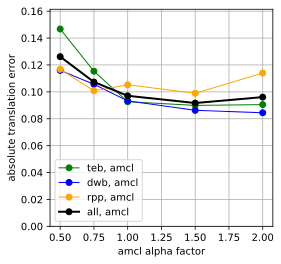

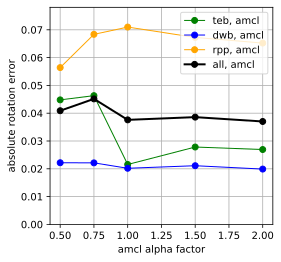

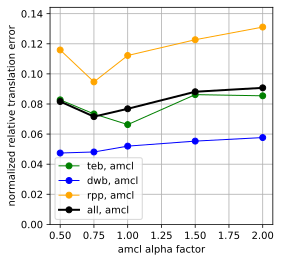

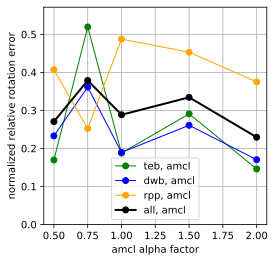

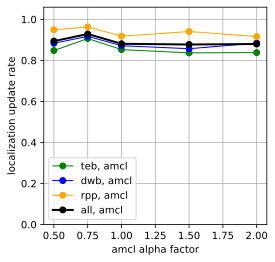

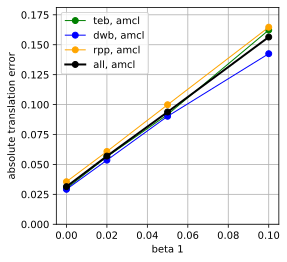

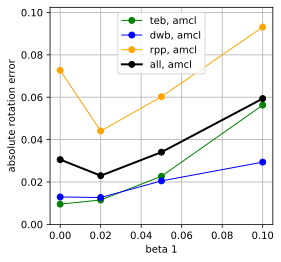

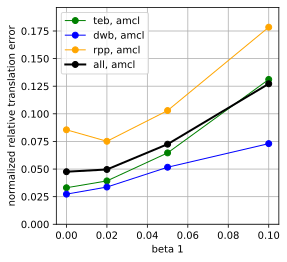

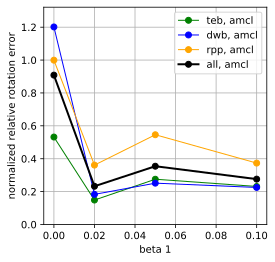

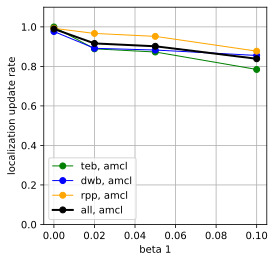

In [9]:
## plots_localization amcl_alpha_factor

min_bin_count = 10

# df_localization_plots_aaf = df[(df.collisionless_success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.amcl_alpha_factor != 0.0)].copy()
df_localization_plots_aaf = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.amcl_alpha_factor != 0.0)].copy()
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_aaf.absolute_translation_error, 
    input_metrics=[df_localization_plots_aaf.amcl_alpha_factor], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_aaf,
    out_dir="plots_localization_all_runs",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_aaf.absolute_rotation_error, 
    input_metrics=[df_localization_plots_aaf.amcl_alpha_factor], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_aaf,
    out_dir="plots_localization_all_runs",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_aaf.normalized_relative_translation_error, 
    input_metrics=[df_localization_plots_aaf.amcl_alpha_factor], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_aaf,
    out_dir="plots_localization_all_runs",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_aaf.normalized_relative_rotation_error, 
    input_metrics=[df_localization_plots_aaf.amcl_alpha_factor], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_aaf,
    out_dir="plots_localization_all_runs",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_aaf.localization_update_rate, 
    input_metrics=[df_localization_plots_aaf.amcl_alpha_factor], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_aaf,
    out_dir="plots_localization_all_runs",
)

## plots_localization beta_1

df_localization_plots_beta = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_beta.absolute_translation_error, 
    input_metrics=[df_localization_plots_beta.beta_1], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_beta,
    out_dir="plots_localization_all_runs",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_beta.absolute_rotation_error, 
    input_metrics=[df_localization_plots_beta.beta_1], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_beta,
    out_dir="plots_localization_all_runs",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_beta.normalized_relative_translation_error, 
    input_metrics=[df_localization_plots_beta.beta_1], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_beta,
    out_dir="plots_localization_all_runs",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_beta.normalized_relative_rotation_error, 
    input_metrics=[df_localization_plots_beta.beta_1], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_beta,
    out_dir="plots_localization_all_runs",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_beta.localization_update_rate, 
    input_metrics=[df_localization_plots_beta.beta_1], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_beta,
    out_dir="plots_localization_all_runs",
)

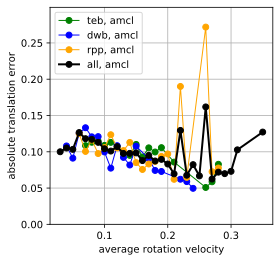

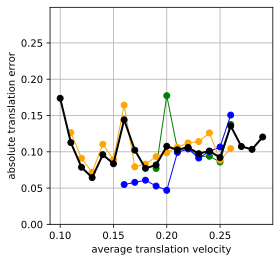

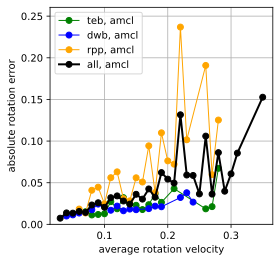

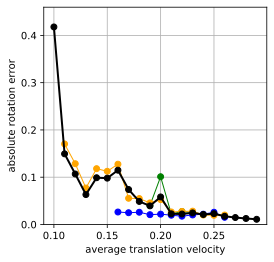

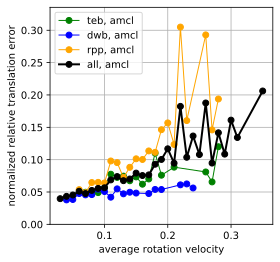

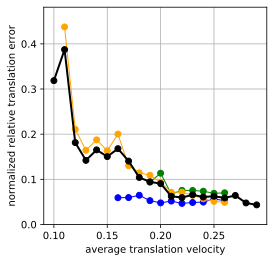

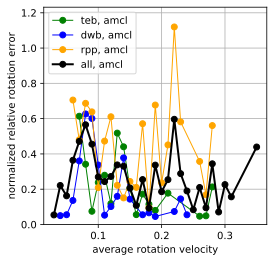

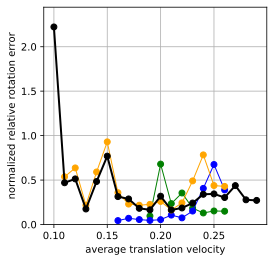

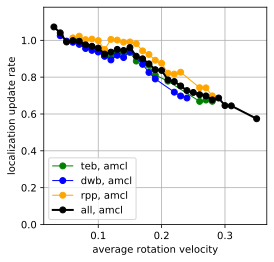

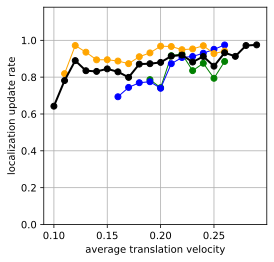

In [10]:
## plots_localization average_rotation_velocity average_translation_velocity

df_localization_plots_rot = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_rot.absolute_translation_error, 
    input_metrics=[df_localization_plots_rot.average_rotation_velocity, df_localization_plots_rot.average_translation_velocity], 
    bin_widths=[0.01, 0.01],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_rot,
    out_dir="plots_localization_all_runs",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_rot.absolute_rotation_error, 
    input_metrics=[df_localization_plots_rot.average_rotation_velocity, df_localization_plots_rot.average_translation_velocity], 
    bin_widths=[0.01, 0.01],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_rot,
    out_dir="plots_localization_all_runs",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_rot.normalized_relative_translation_error, 
    input_metrics=[df_localization_plots_rot.average_rotation_velocity, df_localization_plots_rot.average_translation_velocity], 
    bin_widths=[0.01, 0.01],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_rot,
    out_dir="plots_localization_all_runs",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_rot.normalized_relative_rotation_error, 
    input_metrics=[df_localization_plots_rot.average_rotation_velocity, df_localization_plots_rot.average_translation_velocity], 
    bin_widths=[0.01, 0.01],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_rot,
    out_dir="plots_localization_all_runs",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_rot.localization_update_rate, 
    input_metrics=[df_localization_plots_rot.average_rotation_velocity, df_localization_plots_rot.average_translation_velocity], 
    bin_widths=[0.01, 0.01],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_rot,
    out_dir="plots_localization_all_runs",
)

In [ ]:
## plots_localization amcl_alpha_factor

min_bin_count = 10

df_localization_plots_aaf = df[(df.collisionless_success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.amcl_alpha_factor != 0.0)].copy()
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_aaf.absolute_translation_error, 
    input_metrics=[df_localization_plots_aaf.amcl_alpha_factor], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_aaf,
    out_dir="plots_localization_only_successful_nav",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_aaf.absolute_rotation_error, 
    input_metrics=[df_localization_plots_aaf.amcl_alpha_factor], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_aaf,
    out_dir="plots_localization_only_successful_nav",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_aaf.normalized_relative_translation_error, 
    input_metrics=[df_localization_plots_aaf.amcl_alpha_factor], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_aaf,
    out_dir="plots_localization_only_successful_nav",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_aaf.normalized_relative_rotation_error, 
    input_metrics=[df_localization_plots_aaf.amcl_alpha_factor], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_aaf,
    out_dir="plots_localization_only_successful_nav",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_aaf.localization_update_rate, 
    input_metrics=[df_localization_plots_aaf.amcl_alpha_factor], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_aaf,
    out_dir="plots_localization_only_successful_nav",
)

## plots_localization beta_1

df_localization_plots_beta = df[(df.collisionless_success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_beta.absolute_translation_error, 
    input_metrics=[df_localization_plots_beta.beta_1], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_beta,
    out_dir="plots_localization_only_successful_nav",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_beta.absolute_rotation_error, 
    input_metrics=[df_localization_plots_beta.beta_1], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_beta,
    out_dir="plots_localization_only_successful_nav",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_beta.normalized_relative_translation_error, 
    input_metrics=[df_localization_plots_beta.beta_1], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_beta,
    out_dir="plots_localization_only_successful_nav",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_beta.normalized_relative_rotation_error, 
    input_metrics=[df_localization_plots_beta.beta_1], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_beta,
    out_dir="plots_localization_only_successful_nav",
)
plot_in_out_metrics_bin_width_save(
    output_metric=df_localization_plots_beta.localization_update_rate, 
    input_metrics=[df_localization_plots_beta.beta_1], 
    bin_widths=[None],
    min_bin_count=min_bin_count,
    selected_df=df_localization_plots_beta,
    out_dir="plots_localization_only_successful_nav",
)

In [ ]:
df.groupby(['robot_model', 'local_planner_node', 'max_steering_angle_deg', 'localization_node'])[["collisionless_success_rate", "collision_rate", "average_velocity", "execution_time", "trajectory_length", ]].agg(['mean', 'count']).sort_values(('collisionless_success_rate', 'mean'), ascending=False)

In [ ]:
def bar_plot(metric_name, selected_df, y_columns=['robot_model', 'local_planner_node', 'global_planner_node', 'localization_node'], percentage=False):
    bar_df = selected_df.groupby(y_columns)[metric_name].agg(['mean', 'count']).sort_values(by=('mean'), ascending=False)
    ax = (bar_df.sort_values(by=('mean'), ascending=True)* (100 if percentage else 1) ).plot.barh(y=[('mean')], stacked=True, figsize=[10, 5], grid=True, legend=False)
    ax.set_xlabel(metric_name.replace('_', ' ').replace(',', ', '))
    ax.set_ylabel(ax.get_ylabel().replace('_', ' ').replace(',', ', '))
    plt.show()

bar_plot(metric_name='collisionless_success_rate', selected_df=df[(df.max_steering_angle_deg == 90.0)], percentage=True)
bar_plot(metric_name='collision_rate', selected_df=df[(df.max_steering_angle_deg == 90.0)], percentage=True)
bar_plot(metric_name='trajectory_length', selected_df=df[(df.collisionless_success_rate == 1) & (df.max_steering_angle_deg == 90.0)])
bar_plot(metric_name='execution_time', selected_df=df[(df.collisionless_success_rate == 1) & (df.max_steering_angle_deg == 90.0)])
bar_plot(metric_name='average_velocity', selected_df=df[(df.collisionless_success_rate == 1) & (df.max_steering_angle_deg == 90.0)])